In [1]:
import os
import re
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from itertools import combinations
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

# Get list of gene and species

In [2]:
dicoGeneListbySp = {}
path = "/home/anais/Documents/Projet/G4Evolution/"
homologyDir = path+'Homology/'
for paths, dirs, files in os.walk(homologyDir):
    # for each element of the directory to passed
    for filename in files: # for each files
        inputfile = homologyDir + filename
        sp = filename.split('.')[0]
        if '.txt' in filename:
            with open(inputfile) as f:
                content = f.read()
                lines = content.split('\n')
                for l in lines:
                    dicoGeneListbySp[l] = sp

# Initialization
## Regex

In [3]:
start = '(?:(?:[G]{1}.[G]{2})|(?:[G]{2}))'
end = '(?:(?:[G]{2}.[G]{1})|(?:[G]{2}))'
dicoRegEx = {'Restrained region': start+'.{1,}'+end,
        'Loops': '(?=([^G]{1,}G{0,1}[^G]{1,}){1,})',
        'G-track': '(?=([G]{3,})|([G]{2,}.[G]{1,})|([G]{1,}.[G]{2,}))',
        'Gtrack with buldge': '(?=([G]{1,}.{1}[G]{1,}))',
        'JM canonical motif': r"(?i)(?P<run>g{3,})(.{1,7}?)(?P=run)(.{1,7}?)"+\
             "(?P=run)(.{1,7}?)(?P=run)",
        'all possible match': '(?=(G{2,}.{1,}G{2,}.{1,}G{2,}.{1,}G{2,}))'}

## Codons
All codons are stocked i na list, except the GGG and codons and those containing GG di-nucleotides. They are removed in order to check the nucleotide content and avoid overrepresentation of G content.

In [4]:
codons = ['ATT', 'ATC', 'ATA', 'CTT', 'CTC', 'CTA', 'CTG', 'TTA', 'TTG', 'GTT',
        'GTC', 'GTA', 'GTG', 'TTT', 'TTC', 'ATG', 'TGT', 'TGC', 'GCT', 'GCC', 'GCA',
        'GCG', 'CCT', 'CCC', 'CCA', 'CCG', 'ACT', 'ACC', 'ACA', 'ACG', 'TCT', 'TCC',
        'TCA', 'TCG', 'AGT', 'AGC', 'TAT', 'TAC', 'CAA', 'CAG', 'AAT', 'AAC', 'CAT',
        'CAC', 'GAA', 'GAG', 'GAT', 'GAC', 'AAA', 'AAG', 'CGT', 'CGC', 'CGA', 'AGA',
        'TAA', 'TAG', 'TGA']

## dico dataFrame

In [5]:
dicoDF = {'Nb G-track': [], 'length G-track': [],
            'Nb G-track with bulges': [], 'Loop length': [],
            'G4NN': [], 'G4H': [], 'cGcC': [], 'LengthRegion': [],
            'Nb canonical': [], 'Nb non canonical': [], 'species': []}
for c in codons:
    dicoDF[c] = []

# Fill dataFrame

In [6]:
genesInTrees = []
trees = subprocess.check_output("ls "+path+"ArcBacEukGeneList/", shell=True)
trees = trees.decode("utf-8")
for tree in trees.split('\n'):
    if tree != '':
        genes = subprocess.check_output("cat "+path+"ArcBacEukGeneList/"+tree, shell=True)
        genes = genes.decode("utf-8")
        genes = genes.split('\n')
        if genes[-1] == '':
            genes = genes[:-1]
        genesInTrees.extend(genes)
genesInTrees = list(set(genesInTrees))

In [7]:
listDD = []
for gene in genesInTrees:
    if gene in dicoGeneListbySp:
        cmd = "cat "+path+"data/"+dicoGeneListbySp[gene]+"/Gene_pG4WT.csv | grep "+gene
        try:
            pG4s = subprocess.check_output(cmd, shell=True)
        except:
            pass
        else:
            pG4s = pG4s.decode("utf-8")
            pG4s = pG4s.split('\n')
            if pG4s[-1] == '':
                pG4s = pG4s[:-1]
            for pG4 in pG4s:
                w = pG4.split('\t')
                start = min(int(w[8]), int(w[9]))
                end = max(int(w[8]), int(w[9]))
                if re.search(dicoRegEx['Restrained region'], w[10]):
                    G4 = re.findall(dicoRegEx['Restrained region'], w[10])[0]
                    loops = re.findall(dicoRegEx['Loops'], G4)
                    gTrack = re.findall(dicoRegEx['G-track'], G4)
                    canonical = re.findall(dicoRegEx['JM canonical motif'], G4)
                    allpG4 = re.findall(dicoRegEx['all possible match'], G4)

                    cptGTrackWithBuldge = 0
                    lenGtrack = []
                    for gt in gTrack:
                        for g in gt:
                            lenGtrack.append(len(g))
                            gTrackWithBludges = re.findall(dicoRegEx['Gtrack with buldge'], g)
                            cptGTrackWithBuldge += len(gTrackWithBludges)

                    for c in codons:
                        cptCodon = 0
                        for l in loops:
                            cptCodon += l.count(c)
                        dicoDF[c].append(cptCodon/float(len(w[10]))*1000)

                    lenLoop = [len(i) for i in loops]
                    if len(lenLoop) > 0:
                        dicoDF['Loop length'].append( sum(lenLoop)/len(lenLoop) )
                    else:
                        loops2 = re.findall('([^G]{1,})', G4)
                        lenLoop2 = [len(i) for i in loops2]
                        if len(lenLoop2) > 0:
                            dicoDF['Loop length'].append( sum(lenLoop2)/len(lenLoop2) )
                        else:
                            dicoDF['Loop length'].append( 0 )
                    if len(lenGtrack) > 0:
                        dicoDF['length G-track'].append( sum(lenGtrack)/len(lenGtrack) )
                    else:
                        gTrack2 = re.findall('[G]{2,}', G4)
                        lenGtrack2 = []
                        for gt in gTrack2:
                            for g in gt:
                                lenGtrack2.append(len(g))
                        if len(lenGtrack2) > 0:
                            dicoDF['length G-track'].append( sum(lenGtrack2)/len(lenGtrack2) )
                        else:
                            dicoDF['length G-track'].append( 0 )
                    dicoDF['Nb G-track'].append( len(gTrack) )
                    dicoDF['Nb G-track with bulges'].append( cptGTrackWithBuldge )
                    dicoDF['cGcC'].append(w[5])
                    dicoDF['G4H'].append(w[6])
                    dicoDF['G4NN'].append(w[7])
                    dicoDF['Nb canonical'].append(len(canonical))
                    nbNonCan = len(allpG4) - len(canonical) +1 / float( len(w[10]) )*1000
                    dicoDF['Nb non canonical'].append(nbNonCan)
                    dicoDF['LengthRegion'].append(len(G4))
                    dicoDF['species'].append(dicoGeneListbySp[gene])
    else:
        listDD.append(gene)
# print(list(set(listDD)))

df = pd.DataFrame(data=dicoDF)
df

Nb G-track  length G-track  Nb G-track with bulges  Loop length  \
0              35        1.466667                      64     4.147059   
1              17        1.392157                      30     3.923077   
2              16        1.395833                      27     4.695652   
3              18        1.370370                      28     2.923077   
4              23        1.550725                      45     4.000000   
...           ...             ...                     ...          ...   
16302          14        1.285714                      22     5.076923   
16303          35        1.514286                      72     5.481481   
16304          15        1.466667                      27     4.076923   
16305          16        1.312500                      26     5.571429   
16306          16        1.354167                      27     6.142857   

                     G4NN                 G4H               cGcC  \
0      0.7160142507905917               0.975  5.937740384615385   
1      0.6227016749737087  1.0166666666666666  7.538461538461539   
2      0.8354379083424501                0.95  6.042424242424242   
3      0.7911681006605541                1.05  4.888888888888889   
4      0.8224198900416402  1.0750000000000002  7.346153846153847   
...                   ...                 ...                ...   
16302  0.6132349966900724  1.1111111111111112  20.36111111111111   
16303   0.903342392652157  1.3216666666666668  73.89166666666667   
16304   0.787848832530015  0.9666666666666668             15.725   
16305  0.7319693566684771  0.9916666666666666            17.1875   
16306  0.8260471296566154                1.05  6.071428571428571   

       LengthRegion  Nb canonical  Nb non canonical  ...         GAC  \
0               117             0         30.692308  ...    0.000000   
1                70             0         22.500000  ...   12.500000   
2                69             0         28.285714  ...  100.000000   
3                59             0         28.666667  ...    0.000000   
4                52             0         26.285714  ...    0.000000   
...             ...           ...               ...  ...         ...   
16302            66             0         23.500000  ...    0.000000   
16303           138             1         37.666667  ...   40.000000   
16304            47             0         23.285714  ...    0.000000   
16305            78             0         21.111111  ...   11.111111   
16306            58             1         24.666667  ...    0.000000   

              AAA        AAG        CGT        CGC         CGA         AGA  \
0       23.076923   0.000000  30.769231   7.692308   15.384615    0.000000   
1        0.000000  25.000000  12.500000  12.500000   12.500000   37.500000   
2        0.000000   0.000000  14.285714  14.285714  100.000000    0.000000   
3        0.000000   0.000000  16.666667  33.333333   16.666667    0.000000   
4        0.000000   0.000000   0.000000  28.571429    0.000000    0.000000   
...           ...        ...        ...        ...         ...         ...   
16302    0.000000   0.000000   0.000000   0.000000    0.000000  175.000000   
16303  133.333333  66.666667   0.000000   0.000000    0.000000  113.333333   
16304    0.000000  14.285714   0.000000   0.000000    0.000000   28.571429   
16305   22.222222  33.333333   0.000000   0.000000    0.000000   55.555556   
16306    0.000000  16.666667   0.000000   0.000000    0.000000  166.666667   

              TAA         TAG        TGA  
0        0.000000    0.000000   0.000000  
1        0.000000   25.000000   0.000000  
2        0.000000    0.000000   0.000000  
3        0.000000    0.000000   0.000000  
4        0.000000    0.000000   0.000000  
...           ...         ...        ...  
16302   37.500000  112.500000   0.000000  
16303  146.666667    0.000000  46.666667  
16304    0.000000    0.000000   0.000000  
16305  100.000000   33.333333  33.333333  
16306    0.000000  150.000

In [8]:
species = df["species"]
dicoSp = {}
cpt = 0
print(list(set(species)))
for sp in list(set(species)):
    dicoSp[sp] = cpt
    cpt +=1
df = df.replace({"species": dicoSp})
# df.species

['pongo_abelii', 'mycobacterium_tuberculosis_h37rv', 'brucella_abortus_bv_1_str_9_941', 'gasterosteus_aculeatus', 'drosophila_melanogaster', 'legionella_pneumophila_str_paris', 'geobacter_sulfurreducens_pca', 'physcomitrella_patens', 'homo_sapiens', 'chlamydomonas_reinhardtii', 'anaplasma_phagocytophilum_str_hz', 'mus_musculus', 'streptococcus_pneumoniae_tigr4', 'halobacterium_salinarum_r1', 'pyrobaculum_aerophilum_str_im2', 'archaeoglobus_fulgidus_dsm_4304', 'campylobacter_jejuni_subsp_jejuni_nctc_11168_atcc_700819', 'candidatus_korarchaeum_cryptofilum_opf8', 'danio_rerio', 'pan_troglodytes', 'chloroflexus_aurantiacus_j_10_fl', 'hyperthermus_butylicus_dsm_5456', 'aspergillus_nidulans', 'enterococcus_faecalis_v583', 'myxococcus_xanthus_dk_1622', 'neurospora_crassa', 'mycoplasma_pneumoniae_m129', 'gallus_gallus', 'caenorhabditis_elegans', 'cenarchaeum_symbiosum_a', 'neisseria_meningitidis_z2491', 'methanosarcina_acetivorans_c2a', 'leishmania_major', 'vitis_vinifera', 'haemophilus_influe

# Correlation before normalization

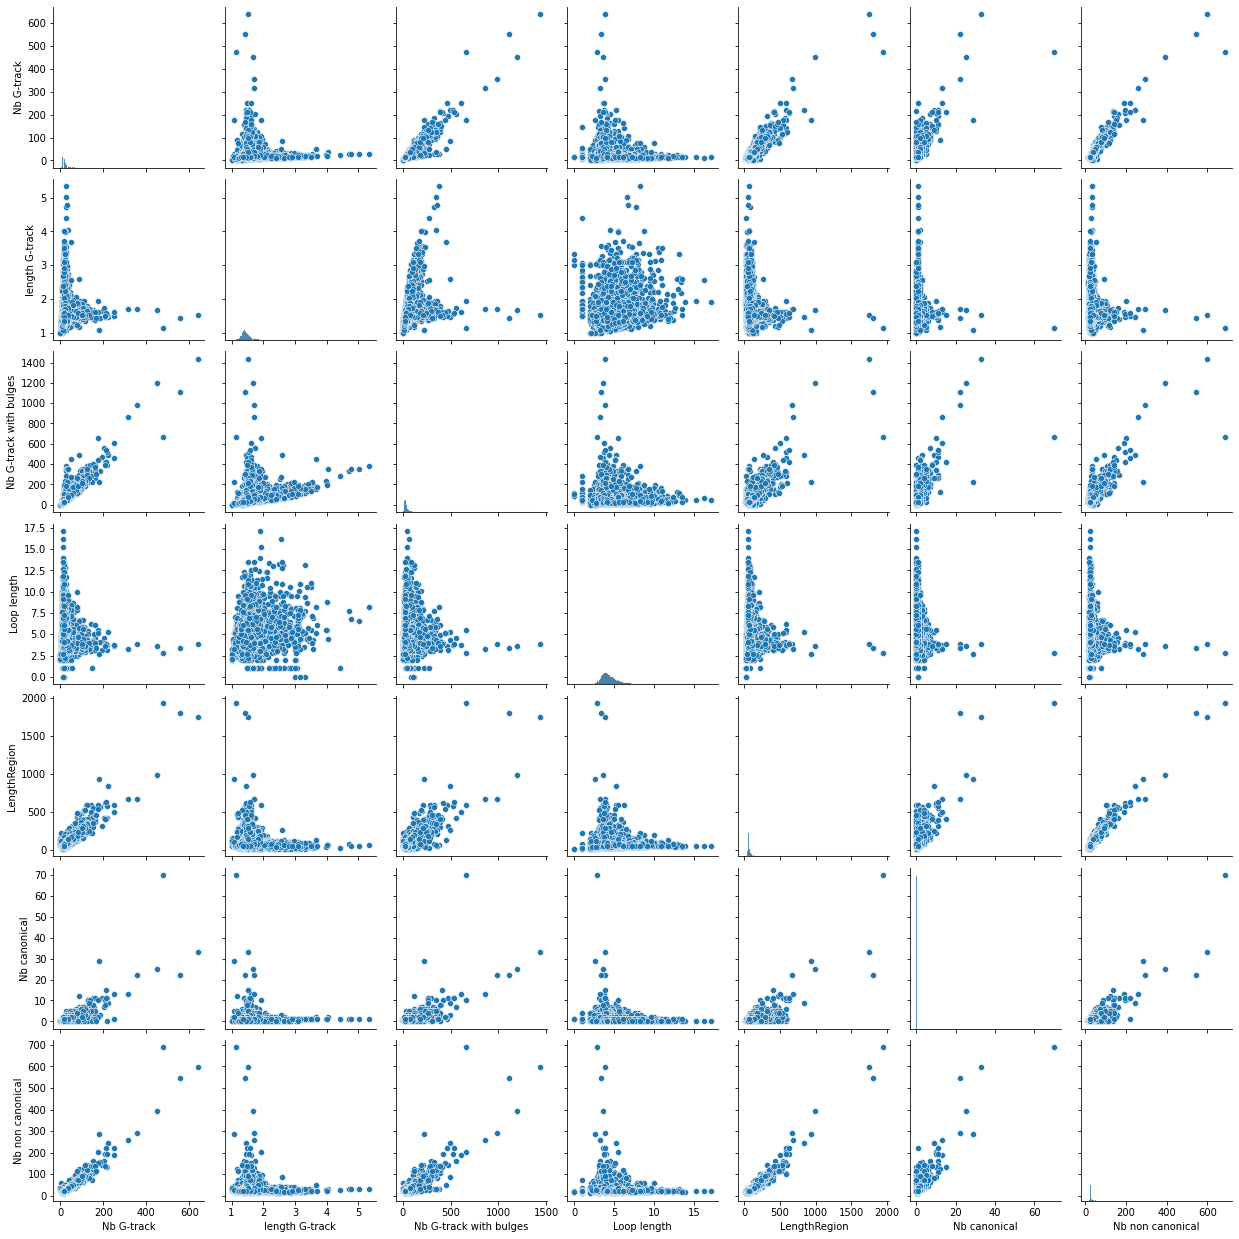

In [9]:
dfTmp = pd.DataFrame()
dfTmp = dfTmp.append(df[['Nb G-track', 'length G-track', 'Nb G-track with bulges',
            'Loop length', 'G4NN', 'G4H', 'cGcC', 'LengthRegion',
            'Nb canonical', 'Nb non canonical']])
sns.pairplot(dfTmp)
plt.show()

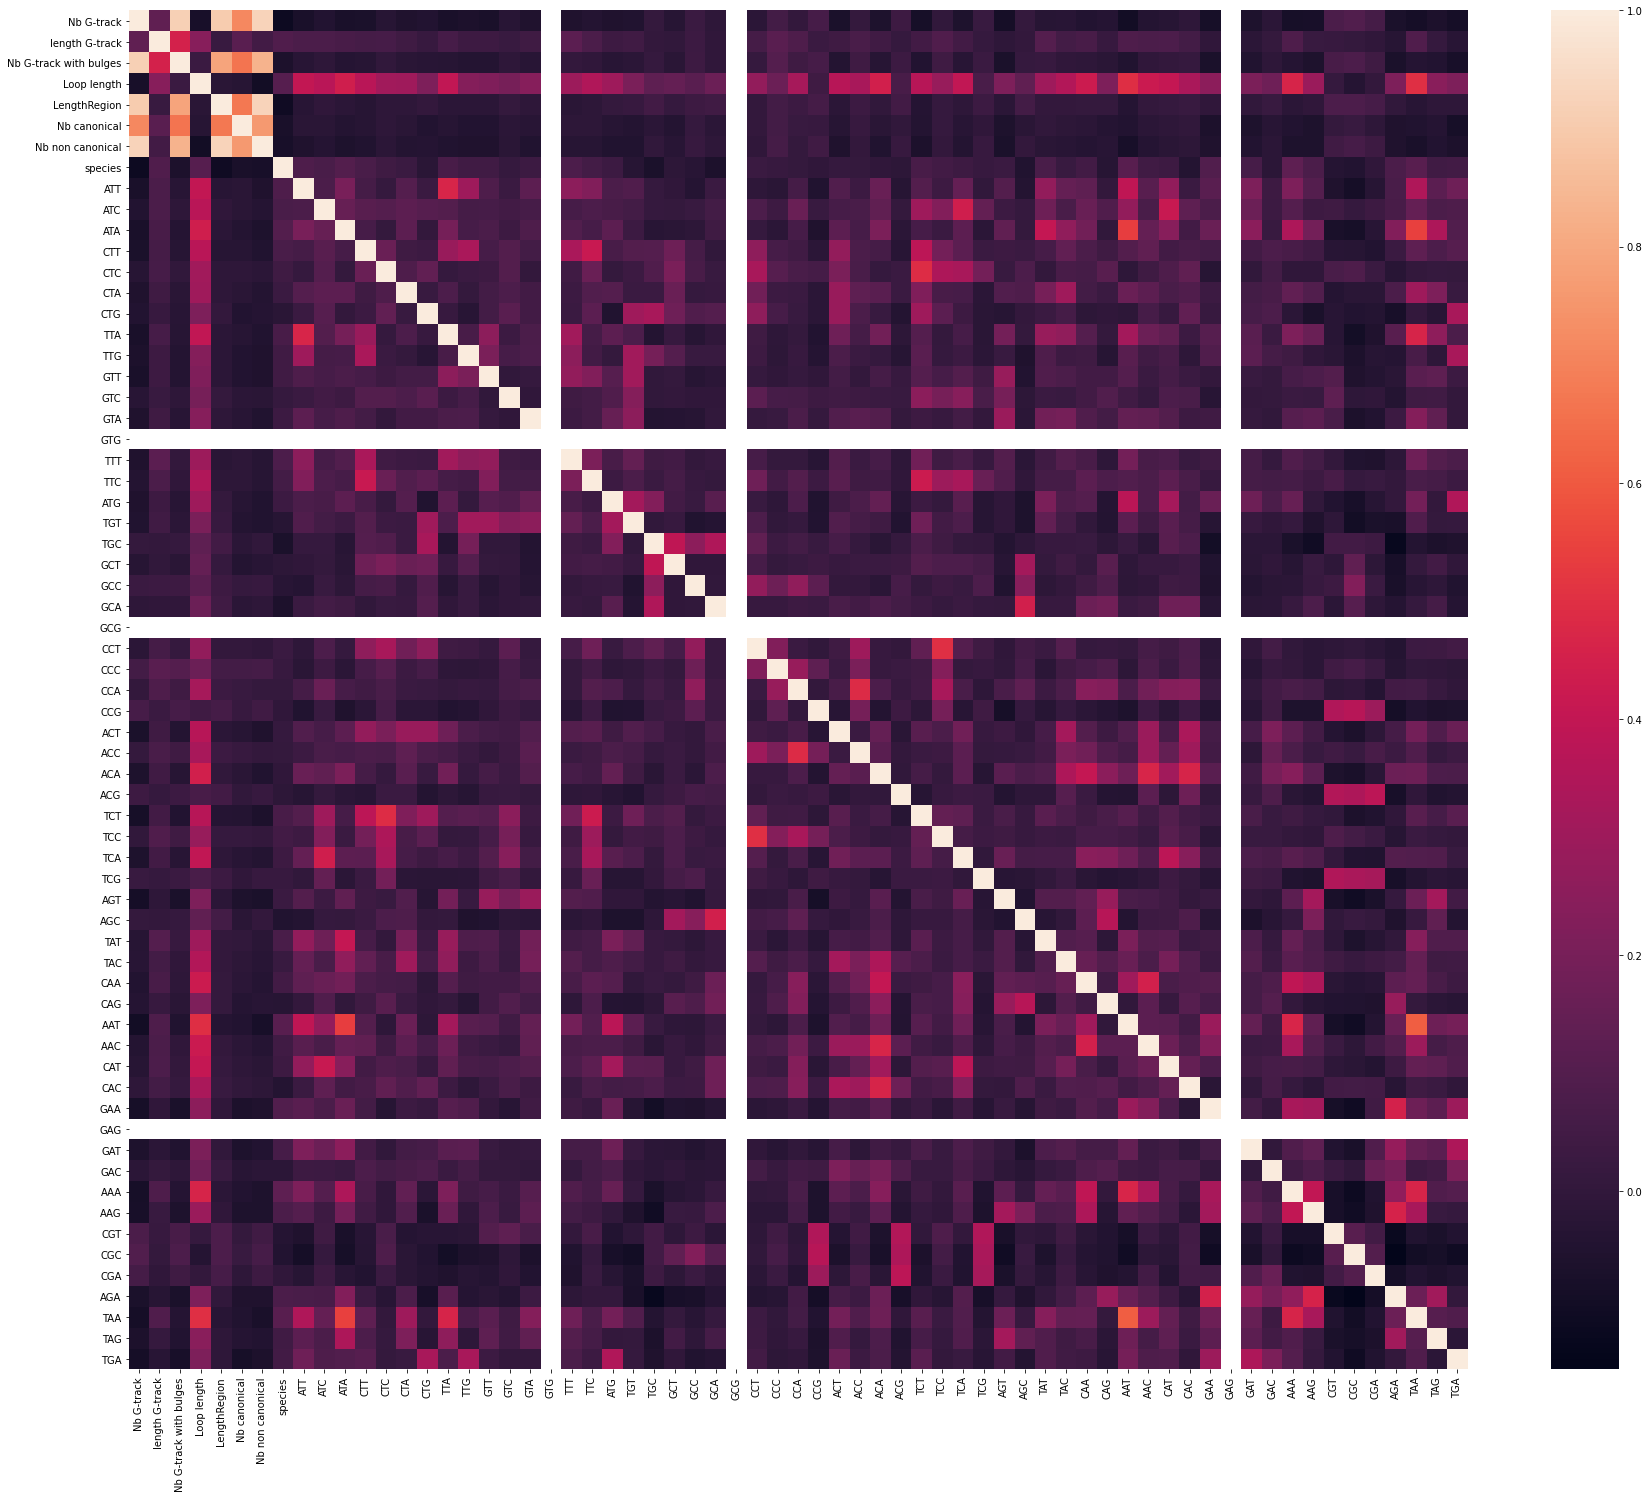

In [10]:
# calculate the correlation matrix
corr = df.corr()

# plot the heatmap
plt.rcParams['figure.figsize'] = [30, 25]
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()

# Normalization by the length of the region

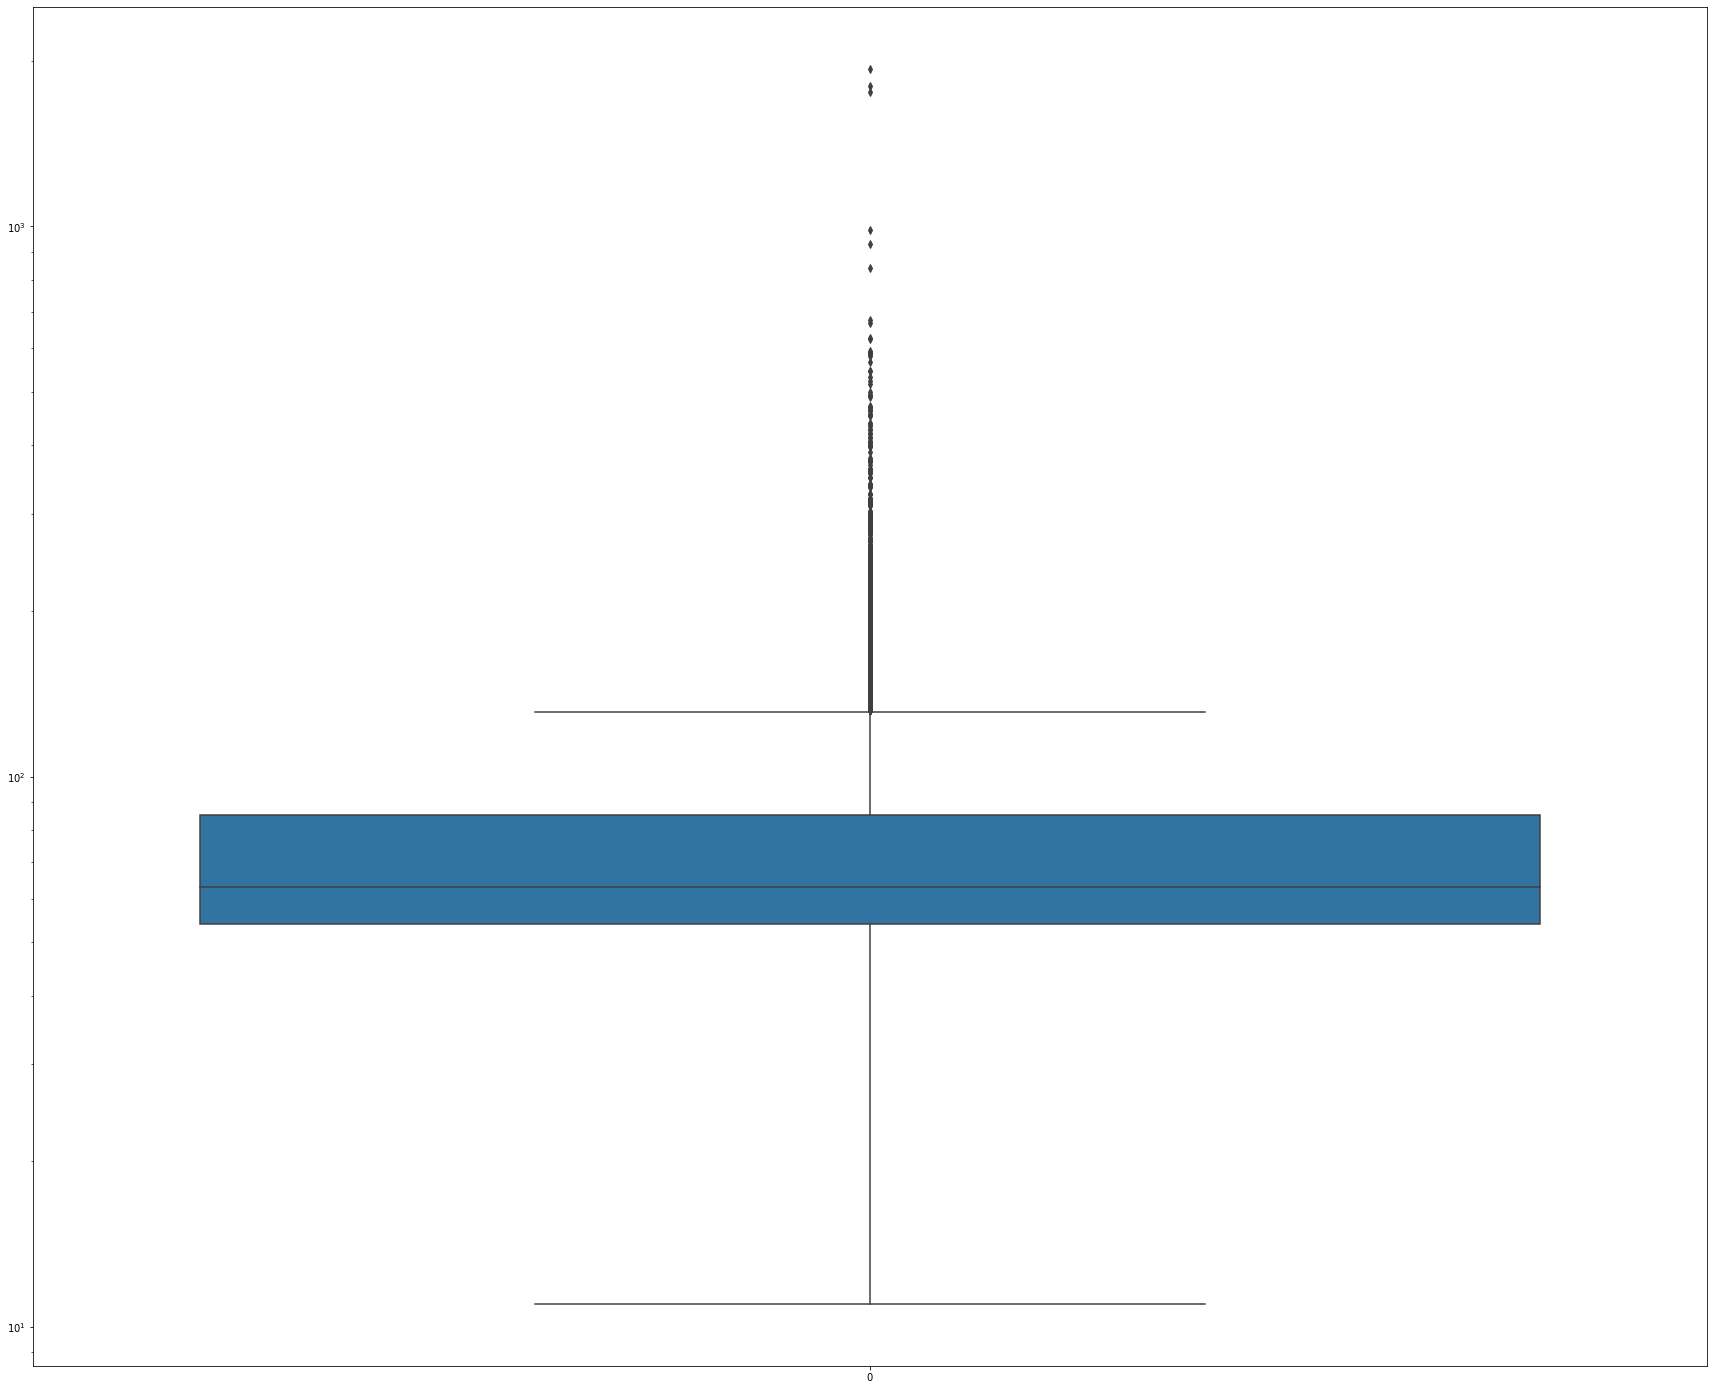

In [11]:
sns.boxplot(data=df['LengthRegion'])
plt.yscale('log')
plt.show()

La majorité des fenêtres sont comprises entre 15 et 110nt, donc je ne vais pas normaliser par la longueur.

# Toute les colonnes
## Test normalisation avec StandardScaler et acp

In [12]:
# Cas avec distance euclidienne

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df)
X_norm = scaler.transform(df)
print(len(X_norm))
print(len(X_norm[0]))
X_norm

16307
68


array([[ 0.81625678, -0.01075236,  0.48665832, ..., -0.39996026,
        -0.4098633 , -0.72808767],
       [-0.19003732, -0.31144591, -0.29818897, ..., -0.39996026,
         0.69627777, -0.72808767],
       [-0.24594255, -0.29660906, -0.3674402 , ..., -0.39996026,
        -0.4098633 , -0.72808767],
       ...,
       [-0.30184778, -0.01075236, -0.3674402 , ..., -0.39996026,
        -0.4098633 , -0.72808767],
       [-0.24594255, -0.63291105, -0.39052394, ...,  1.76748915,
         1.06499147,  0.16276928],
       [-0.24594255, -0.46476005, -0.3674402 , ..., -0.39996026,
         6.22698315,  0.60819776]])

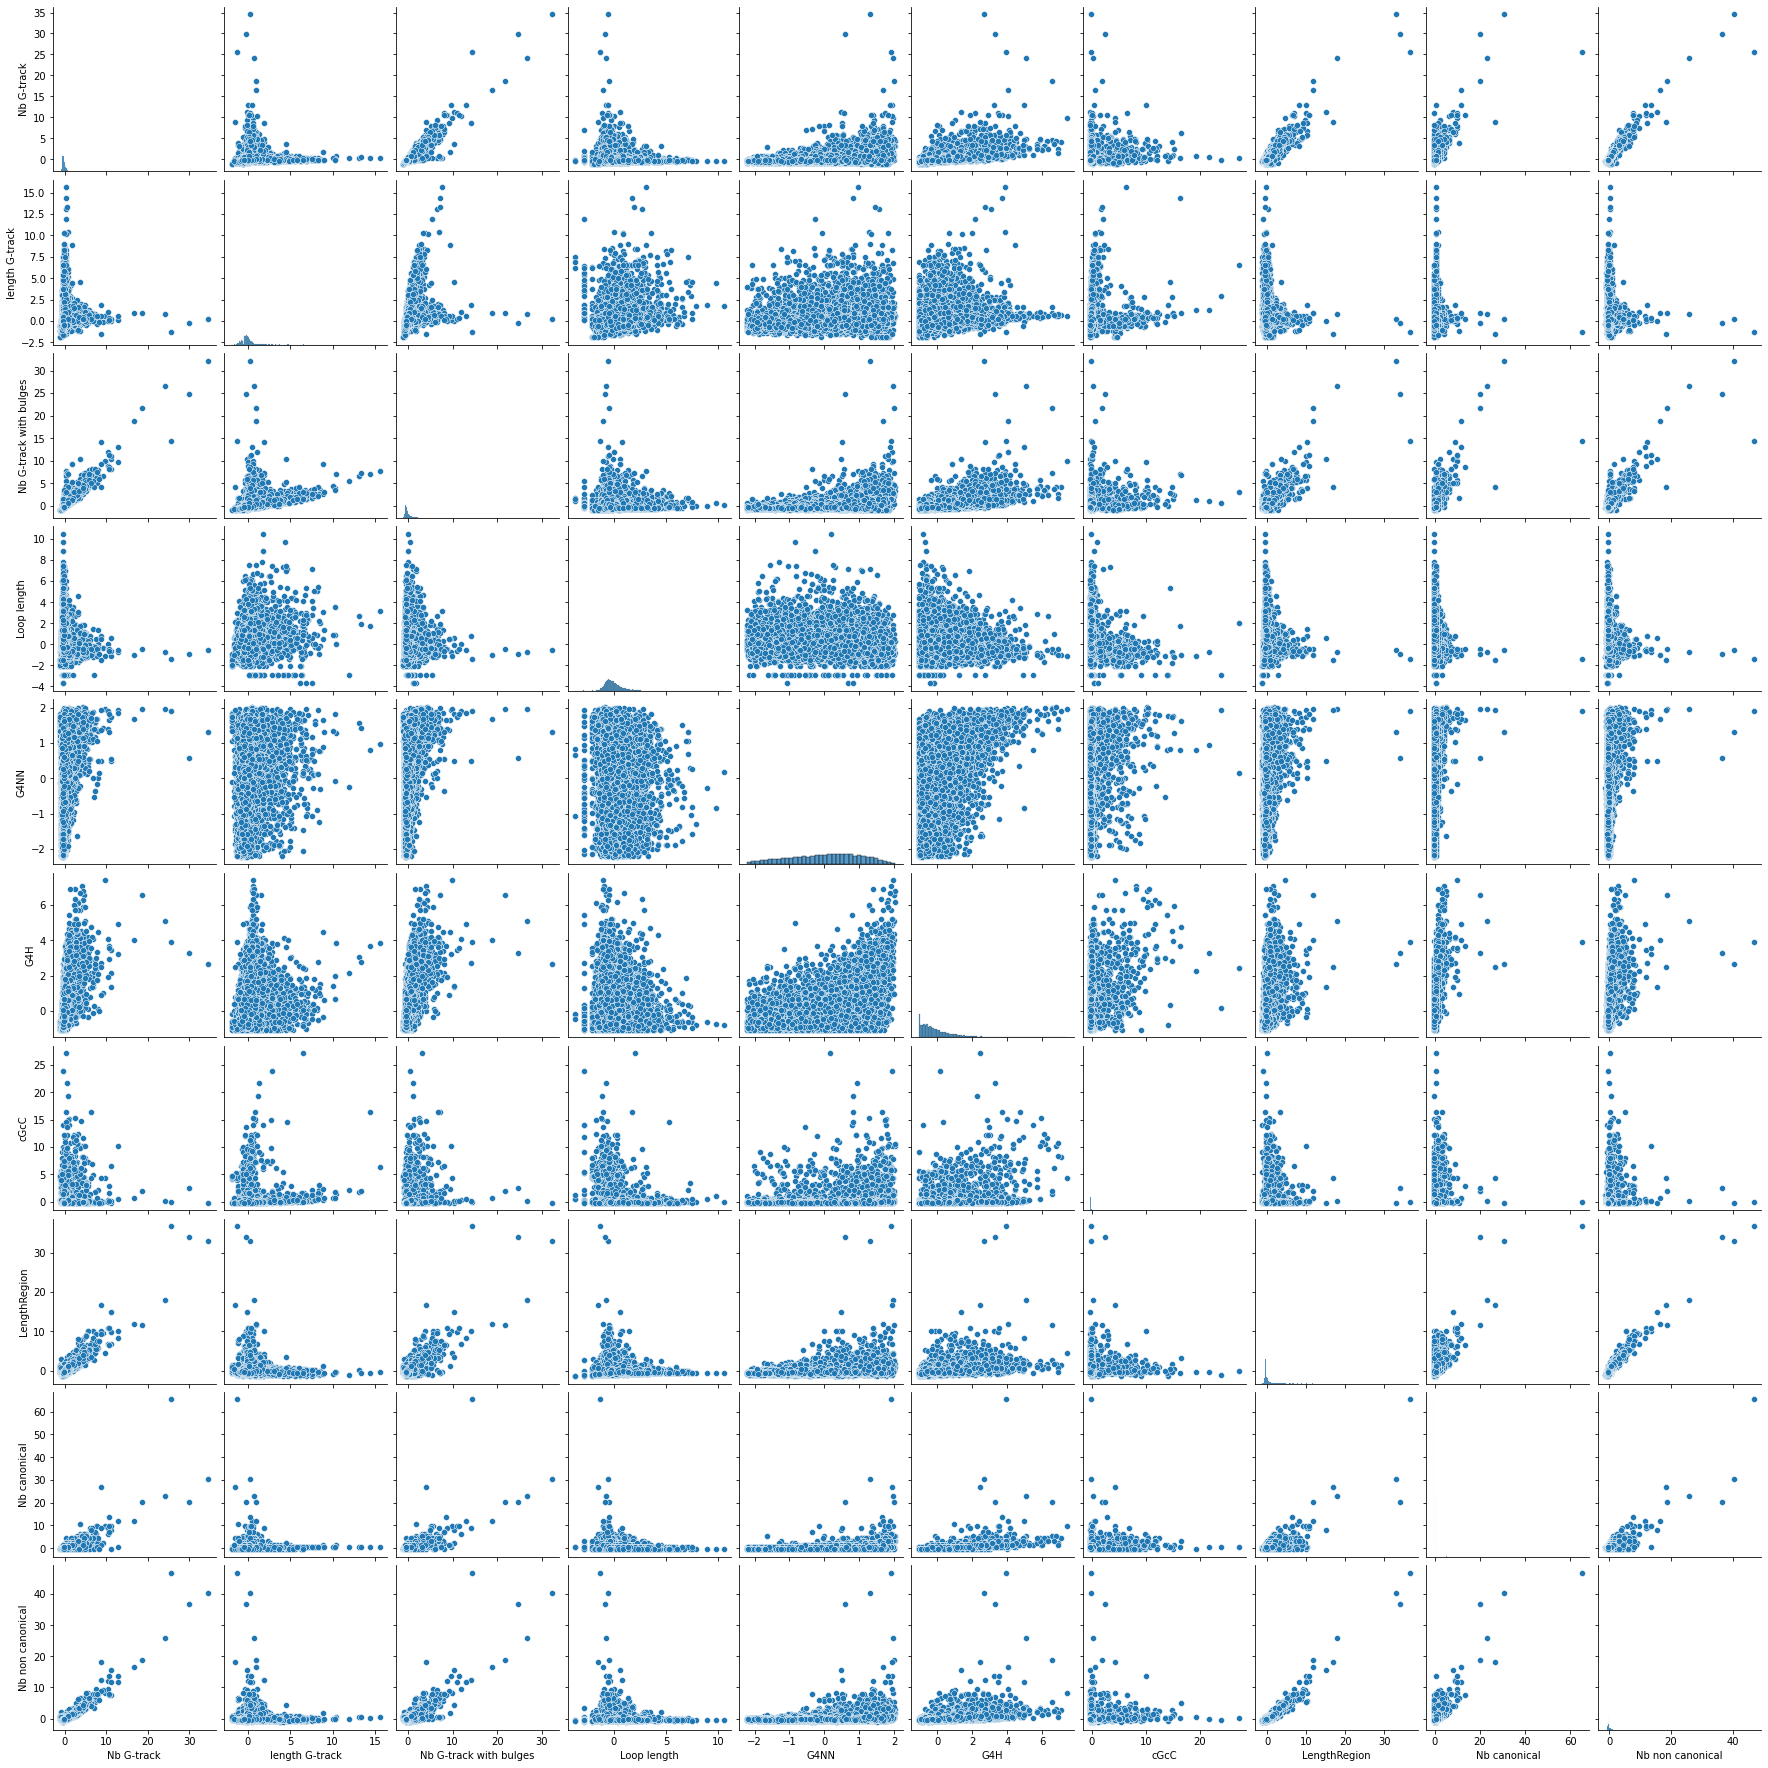

In [13]:
dfNormStdSc = pd.DataFrame(data=X_norm)
dfNormStdSc.columns = df.columns
dfTmp = pd.DataFrame()
dfTmp = dfTmp.append(dfNormStdSc[['Nb G-track', 'length G-track', 'Nb G-track with bulges',
            'Loop length', 'G4NN', 'G4H', 'cGcC', 'LengthRegion',
            'Nb canonical', 'Nb non canonical']])
sns.pairplot(dfTmp)
plt.show()

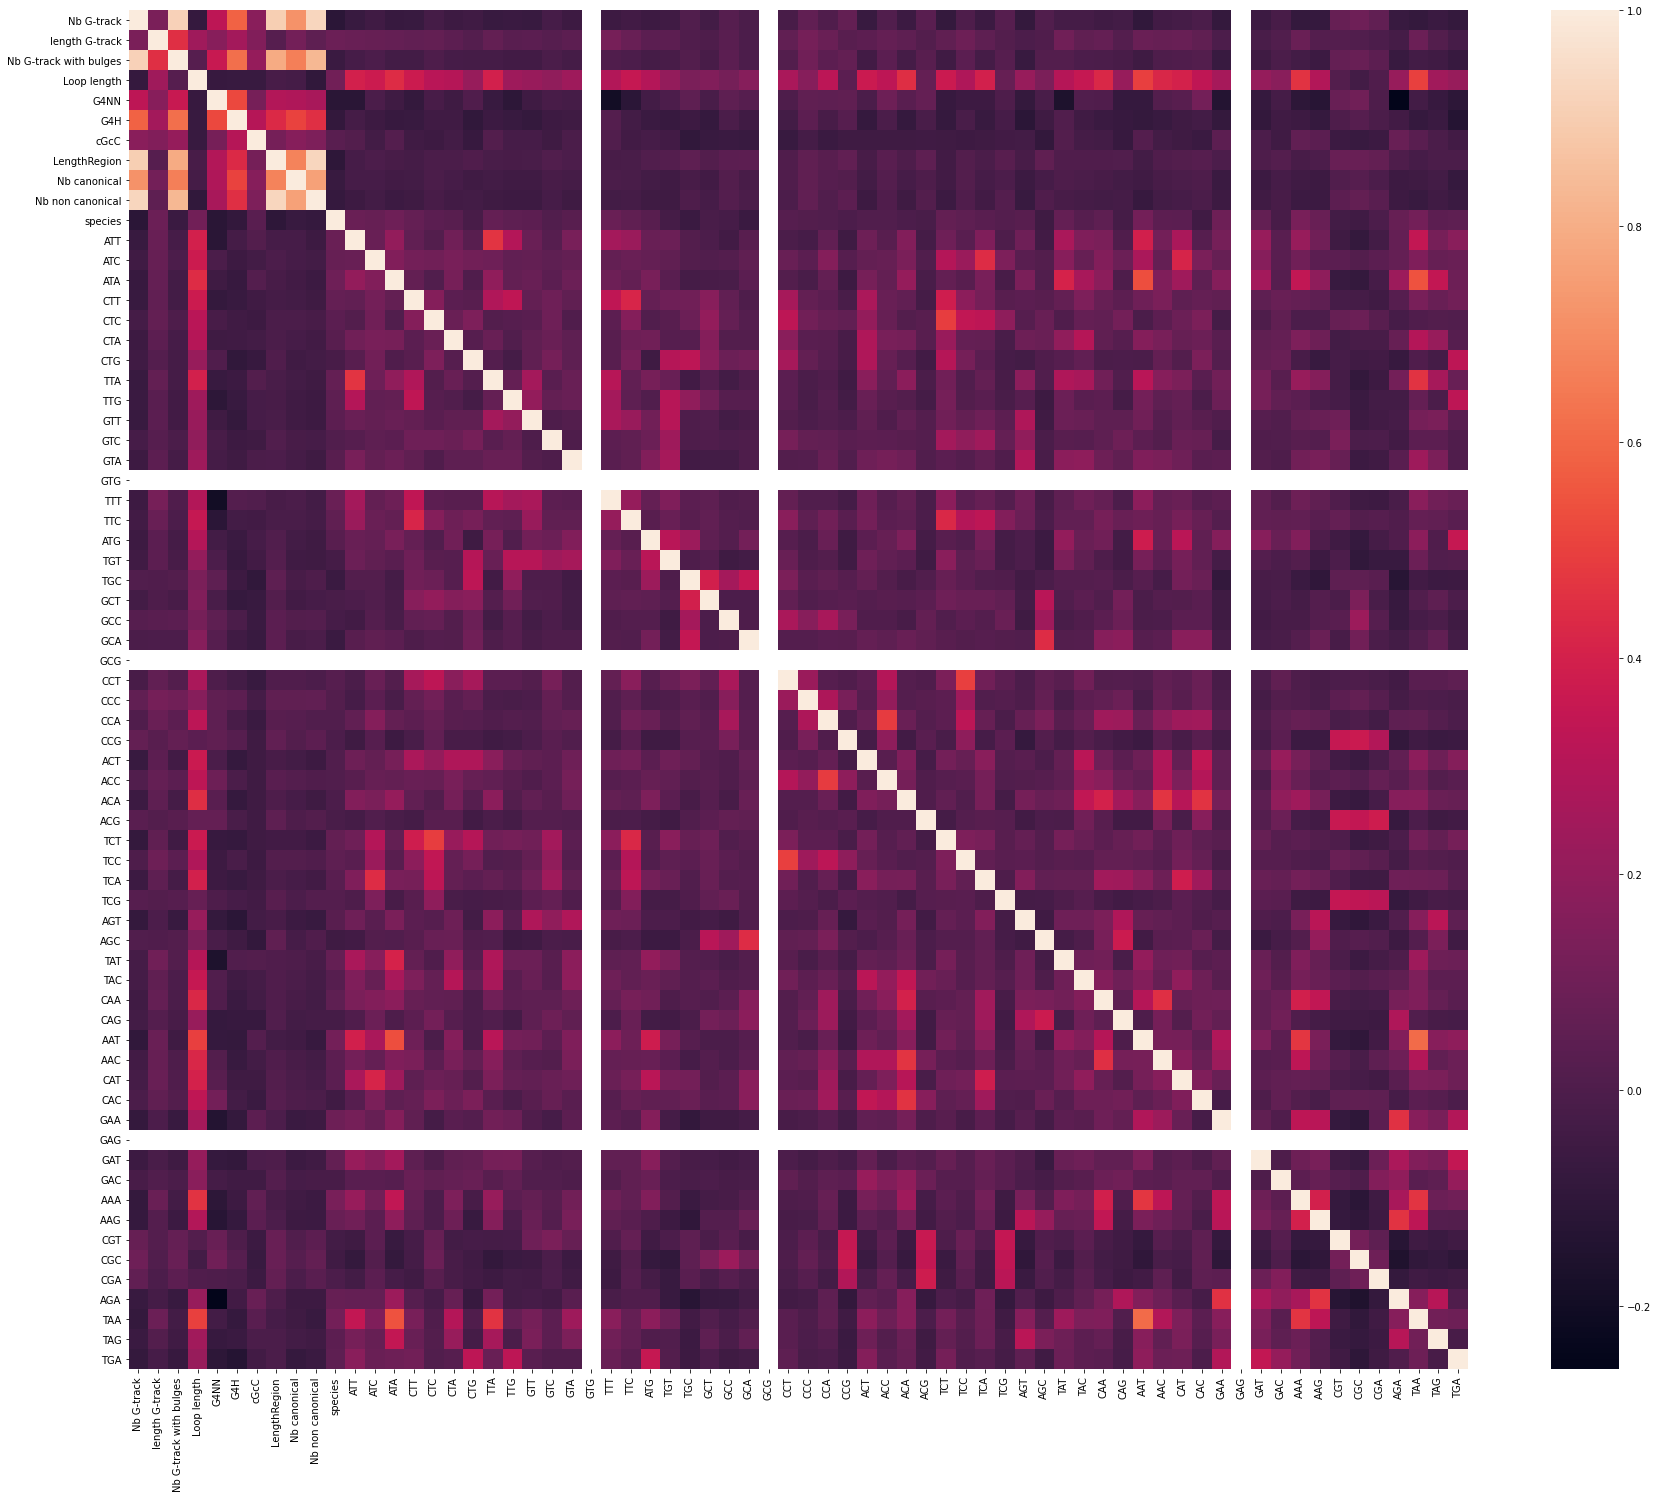

In [14]:
# calculate the correlation matrix
corr = dfNormStdSc.corr()

# plot the heatmap
plt.rcParams['figure.figsize'] = [30, 25]
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()

2
[0.10502937 0.07468107]
3
[0.10502937 0.07468107 0.05350946]
4
[0.10502937 0.07468107 0.05350948 0.03978361]


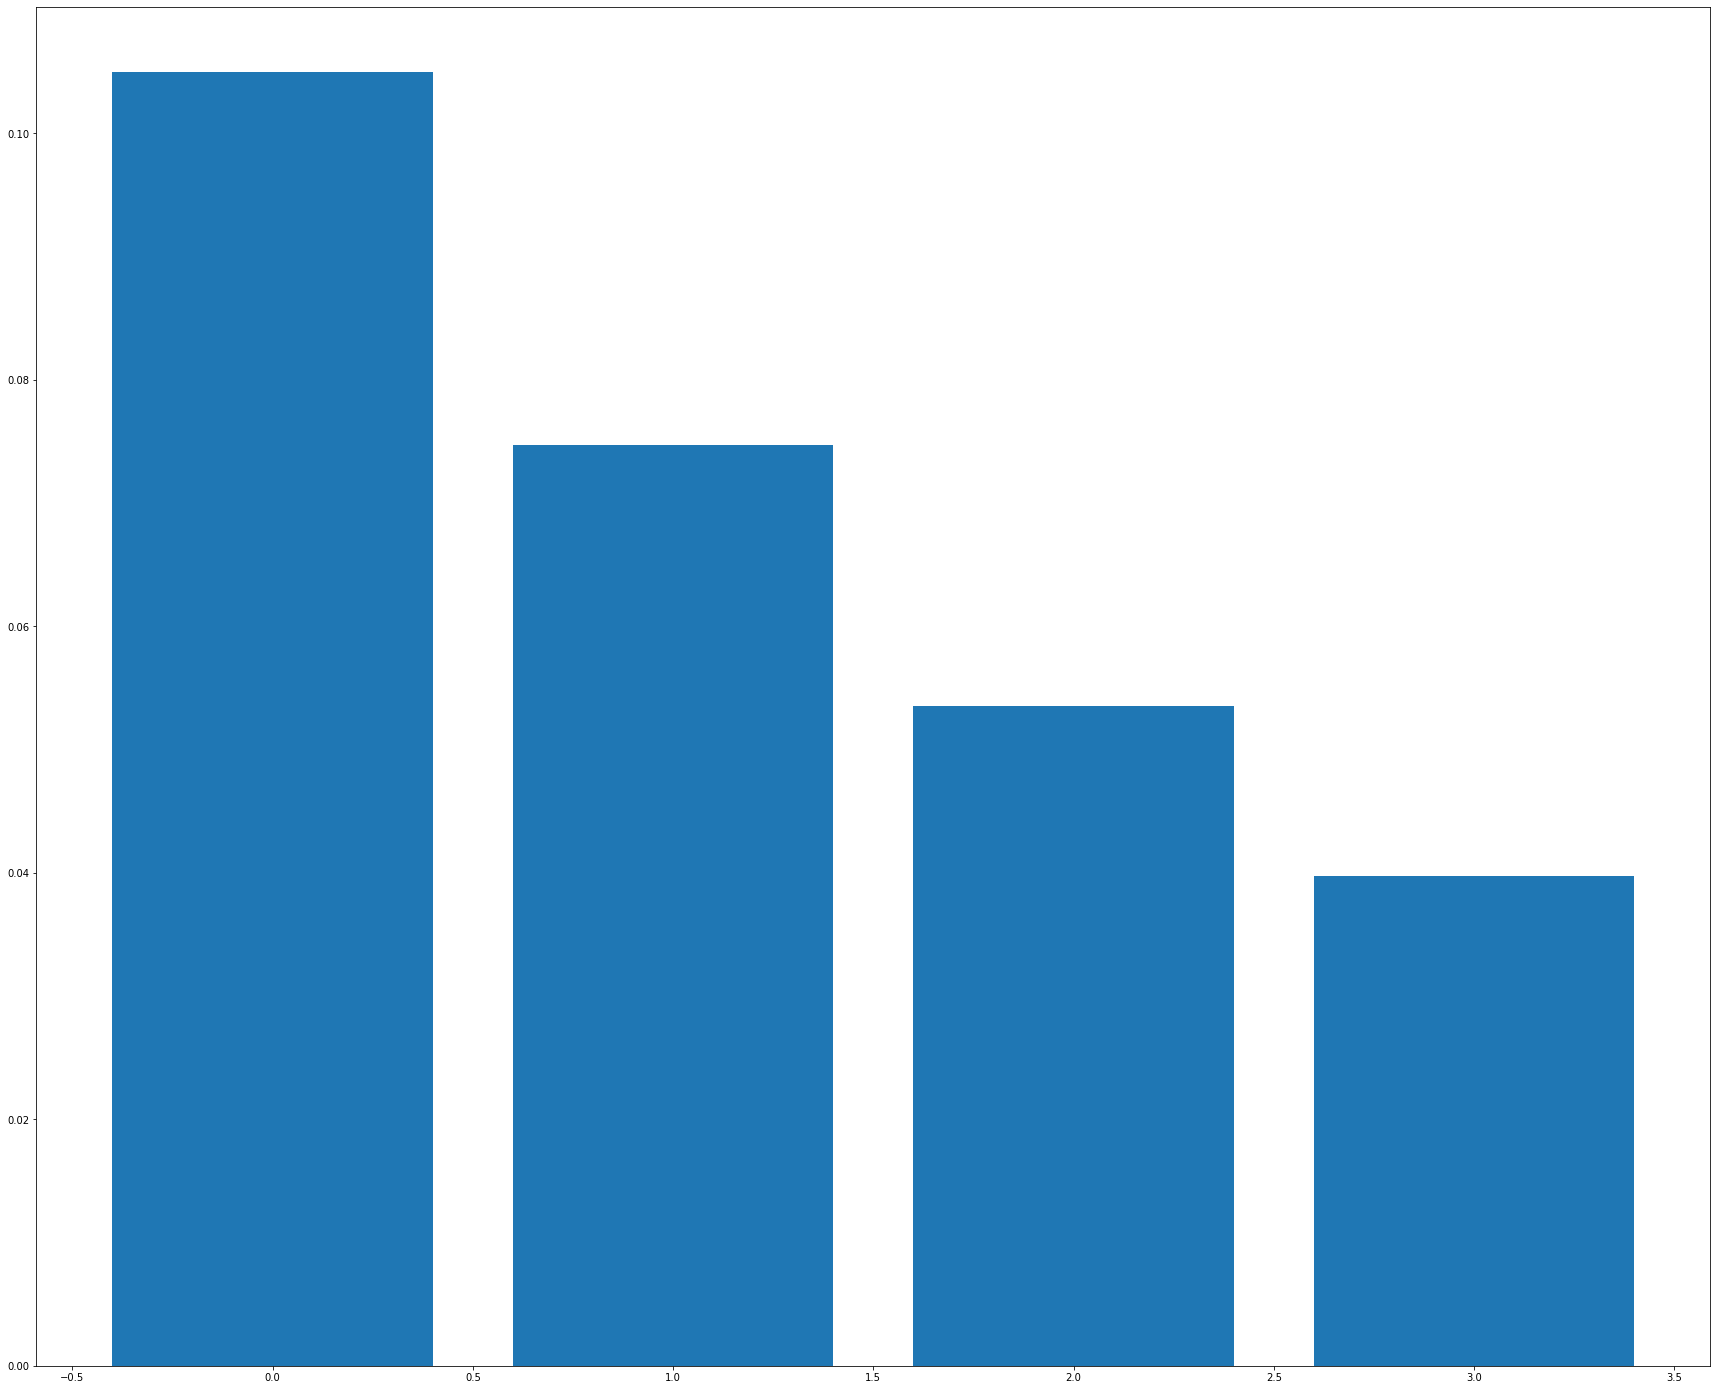

In [15]:
for i in range(2,5):
    print(i)
    pca = PCA(n_components=i)
    pca.fit(dfNormStdSc)
    print(pca.explained_variance_ratio_)
    height = pca.explained_variance_ratio_
    y_pos = np.arange(len(height))

plt.bar(y_pos, height)
plt.show()

Avec l'ACP, on expliquerais ~22% des variances ave 3cp, ce qui est assez peu. Vu qu'il y a peu de corrélation dans les données, cela pouvais être attendu.

Je vais continuer avec la normalization de Standard scale et pas d'ACP

## Test clustering heatmap

In [16]:
for col in dfNormStdSc.columns:
        dfNormStdSc[col] = dfNormStdSc[col].astype('float')

/home/anais/software/projectsVp3/lib/python3.9/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


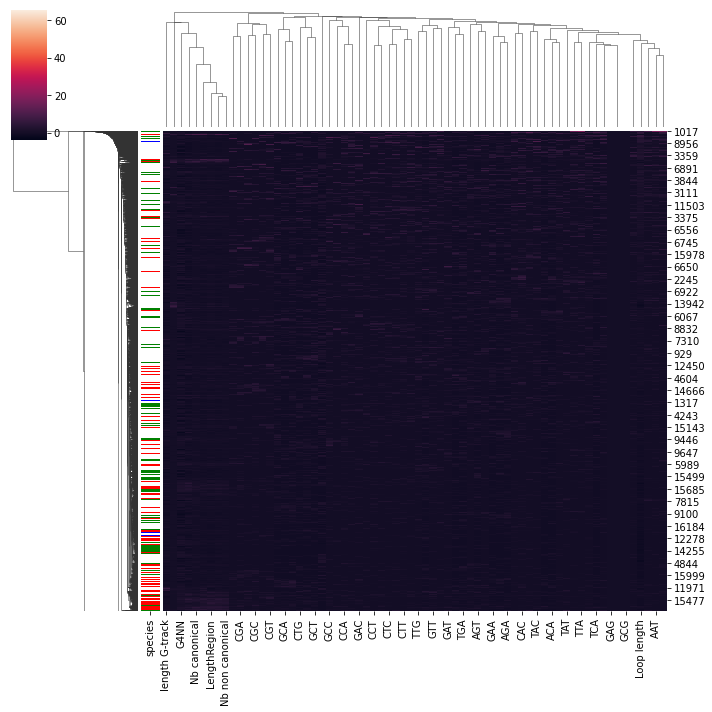

In [17]:
lut = dict(zip(species.unique(), "rbg"))

row_colors = species.map(lut)

g = sns.clustermap(dfNormStdSc, row_colors=row_colors)

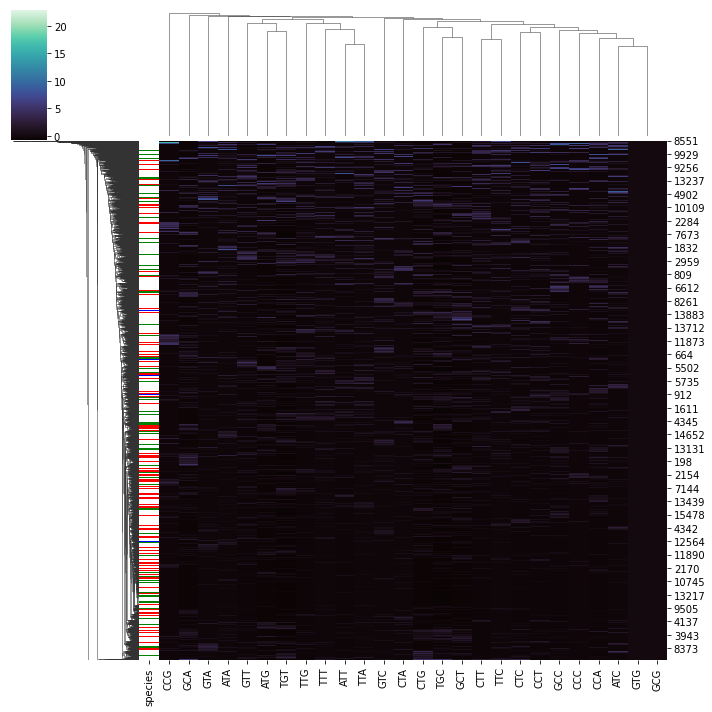

In [18]:
lut = dict(zip(species.unique(), "rbg"))

row_colors = species.map(lut)

g = sns.clustermap(dfNormStdSc[['ATT', 'ATC', 'ATA', 'CTT', 'CTC', 'CTA', 'CTG', 'TTA', 'TTG', 'GTT',
        'GTC', 'GTA', 'GTG', 'TTT', 'TTC', 'ATG', 'TGT', 'TGC', 'GCT', 'GCC', 'GCA',
        'GCG', 'CCT', 'CCC', 'CCA', 'CCG']], row_colors=row_colors, cmap="mako")

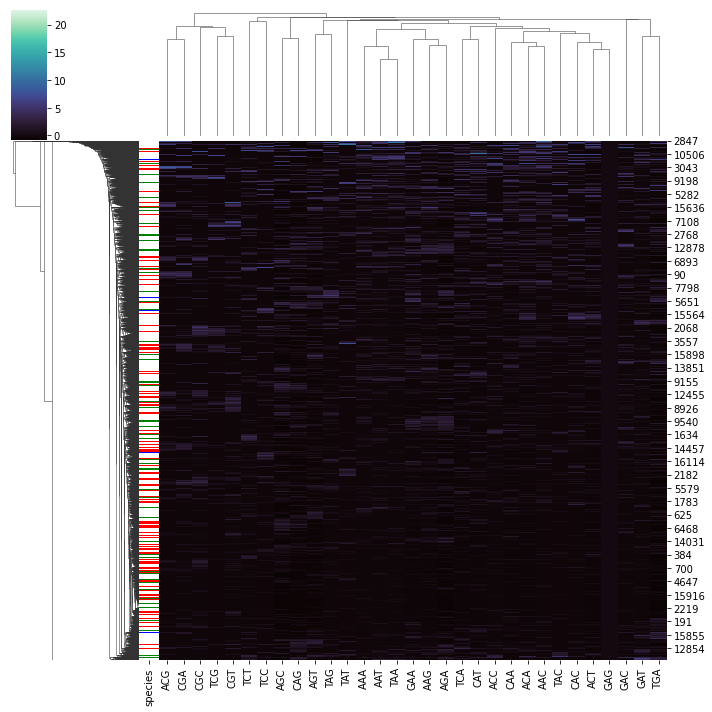

In [19]:
lut = dict(zip(species.unique(), "rbg"))

row_colors = species.map(lut)

g = sns.clustermap(dfNormStdSc[['ACT', 'ACC', 'ACA', 'ACG', 'TCT', 'TCC',
        'TCA', 'TCG', 'AGT', 'AGC', 'TAT', 'TAC', 'CAA', 'CAG', 'AAT', 'AAC', 'CAT',
        'CAC', 'GAA', 'GAG', 'GAT', 'GAC', 'AAA', 'AAG', 'CGT', 'CGC', 'CGA', 'AGA',
        'TAA', 'TAG', 'TGA']], row_colors=row_colors, cmap="mako")

## choix nb cluster

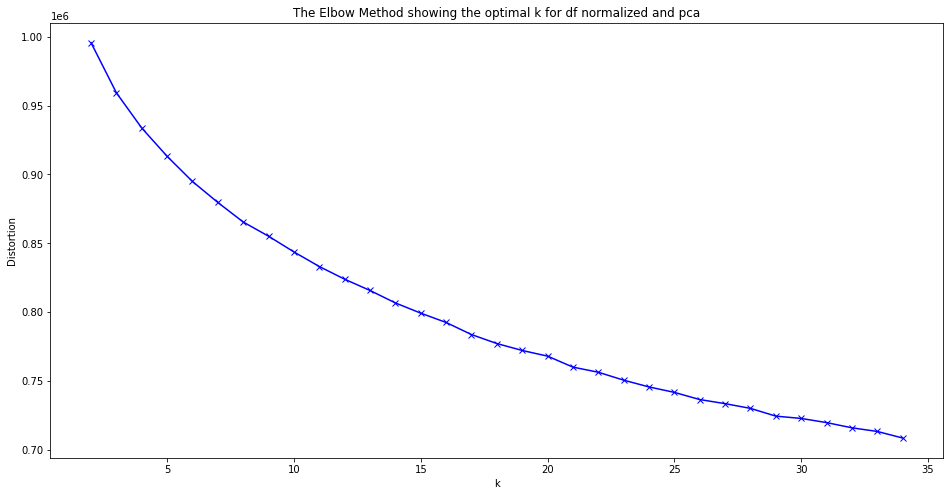

In [20]:
distortions = []
K = range(2,35)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(dfNormStdSc)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k for df normalized and pca')
plt.show()

Le coude semble montrer entre 7 et 11, je vais choisir 9.

For n_clusters = 2 The average silhouette_score is : 0.25220554676749807
For n_clusters = 3 The average silhouette_score is : 0.15078821815152976
For n_clusters = 4 The average silhouette_score is : 0.13322708127353217
For n_clusters = 5 The average silhouette_score is : 0.08910711420422189
For n_clusters = 6 The average silhouette_score is : 0.06604155674198649
For n_clusters = 7 The average silhouette_score is : 0.05923066888448172
For n_clusters = 8 The average silhouette_score is : 0.057154924827688955
For n_clusters = 9 The average silhouette_score is : -0.0029490265822639866
For n_clusters = 10 The average silhouette_score is : 0.0225074853733478
For n_clusters = 11 The average silhouette_score is : 0.00024643566498848136
For n_clusters = 12 The average silhouette_score is : -0.0005042708067724594
For n_clusters = 13 The average silhouette_score is : 7.951473557225446e-05
For n_clusters = 14 The average silhouette_score is : 0.0020151178653532035
For n_clusters = 15 The average s

Text(0.5, 1.0, 'Silhouette showing the optimal k for df normalized')

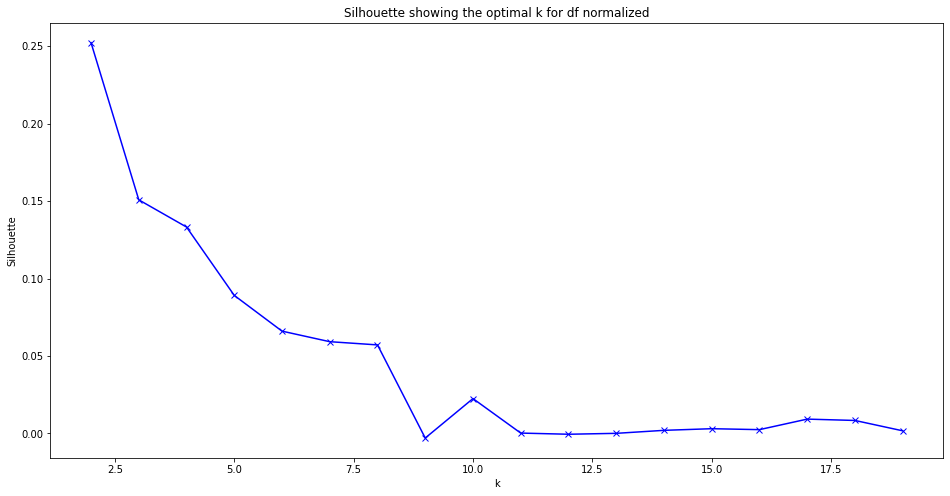

In [21]:
K = range(2,20)
distortions = []

for k in K:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusterer.fit_predict(dfNormStdSc)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(dfNormStdSc, cluster_labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)
    distortions.append(silhouette_avg)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.title('Silhouette showing the optimal k for df normalized')

The best score is 0.25, which is not that much and n=2. So it seems that our data are hard to cluster together.
## kmeans

In [22]:
kmeanModel = KMeans(n_clusters=9)
dfNormStdSc['Cluster'] = kmeanModel.fit_predict(dfNormStdSc)
dfNormStdSc

Nb G-track  length G-track  Nb G-track with bulges  Loop length  \
0        0.816257       -0.010752                0.486658    -0.280897   
1       -0.190037       -0.311446               -0.298189    -0.466873   
2       -0.245943       -0.296609               -0.367440     0.174608   
3       -0.134132       -0.399368               -0.344356    -1.297187   
4        0.145394        0.328474                0.048067    -0.403002   
...           ...             ...                     ...          ...   
16302   -0.357753       -0.741008               -0.482859     0.491182   
16303    0.816257        0.181420                0.671328     0.827093   
16304   -0.301848       -0.010752               -0.367440    -0.339132   
16305   -0.245943       -0.632911               -0.390524     0.901778   
16306   -0.245943       -0.464760               -0.367440     1.376243   

           G4NN       G4H      cGcC  LengthRegion  Nb canonical  \
0     -0.346493 -0.677408 -0.215660      0.793498     -0.394871   
1     -1.156651 -0.461176 -0.202066     -0.133179     -0.394871   
2      0.690366 -0.807147 -0.214771     -0.152896     -0.394871   
3      0.306007 -0.288190 -0.224567     -0.350061     -0.394871   
4      0.577341 -0.158451 -0.203699     -0.488077     -0.394871   
...         ...       ...       ...           ...           ...   
16302 -1.238843  0.028950 -0.093175     -0.212046     -0.394871   
16303  1.279926  1.121642  0.361410      1.207545      0.543783   
16304  0.277189 -0.720654 -0.132546     -0.586660     -0.394871   
16305 -0.207968 -0.590915 -0.120126      0.024553     -0.394871   
16306  0.608834 -0.288190 -0.214524     -0.369778      0.543783   

       Nb non canonical  ...       AAA       AAG       CGT       CGC  \
0              0.180596  ... -0.027209 -0.564516  1.062165 -0.098111   
1             -0.401526  ... -0.472208  0.285458  0.171375  0.117118   
2              0.009590  ... -0.472208 -0.564516  0.258445  0.197060   
3              0.036660  ... -0.472208 -0.564516  0.374538  1.049777   
4             -0.132524  ... -0.472208 -0.564516 -0.438112  0.836597   
...                 ...  ...       ...       ...       ...       ...   
16302         -0.330469  ... -0.472208 -0.564516 -0.438112 -0.442478   
16303          0.676174  ...  2.098895  1.702080 -0.438112 -0.442478   
16304         -0.345695  ... -0.472208 -0.078816 -0.438112 -0.442478   
16305         -0.500216  ... -0.043691  0.568782 -0.438112 -0.442478   
16306         -0.247569  ... -0.472208  0.002133 -0.438112 -0.442478   

            CGA       AGA       TAA       TAG       TGA  Cluster  
0      0.372071 -0.749501 -0.399960 -0.409863 -0.728088        2  
1      0.222466  0.119392 -0.399960  0.696278 -0.728088        4  
2      4.760482 -0.749501 -0.399960 -0.409863 -0.728088        3  
3      0.438562 -0.749501 -0.399960 -0.409863 -0.728088        2  
4     -0.425822 -0.749501 -0.399960 -0.409863 -0.728088        2  
...         ...       ...       ...       ...       ...      ...  
16302 -0.425822  3.305331  0.412833  4.567772 -0.728088        5  
16303 -0.425822  1.876486  2.778966 -0.409863  0.519112        5  
16304 -0.425822 -0.087487 -0.399960 -0.409863 -0.728088        2  
16305 -0.425822  0.537747  1.767489  1.064991  0.162769        5  
16306 -0.425822  3.112244 -0.399960  6.226983  0.608198        5  

[16307 rows x 69 columns]

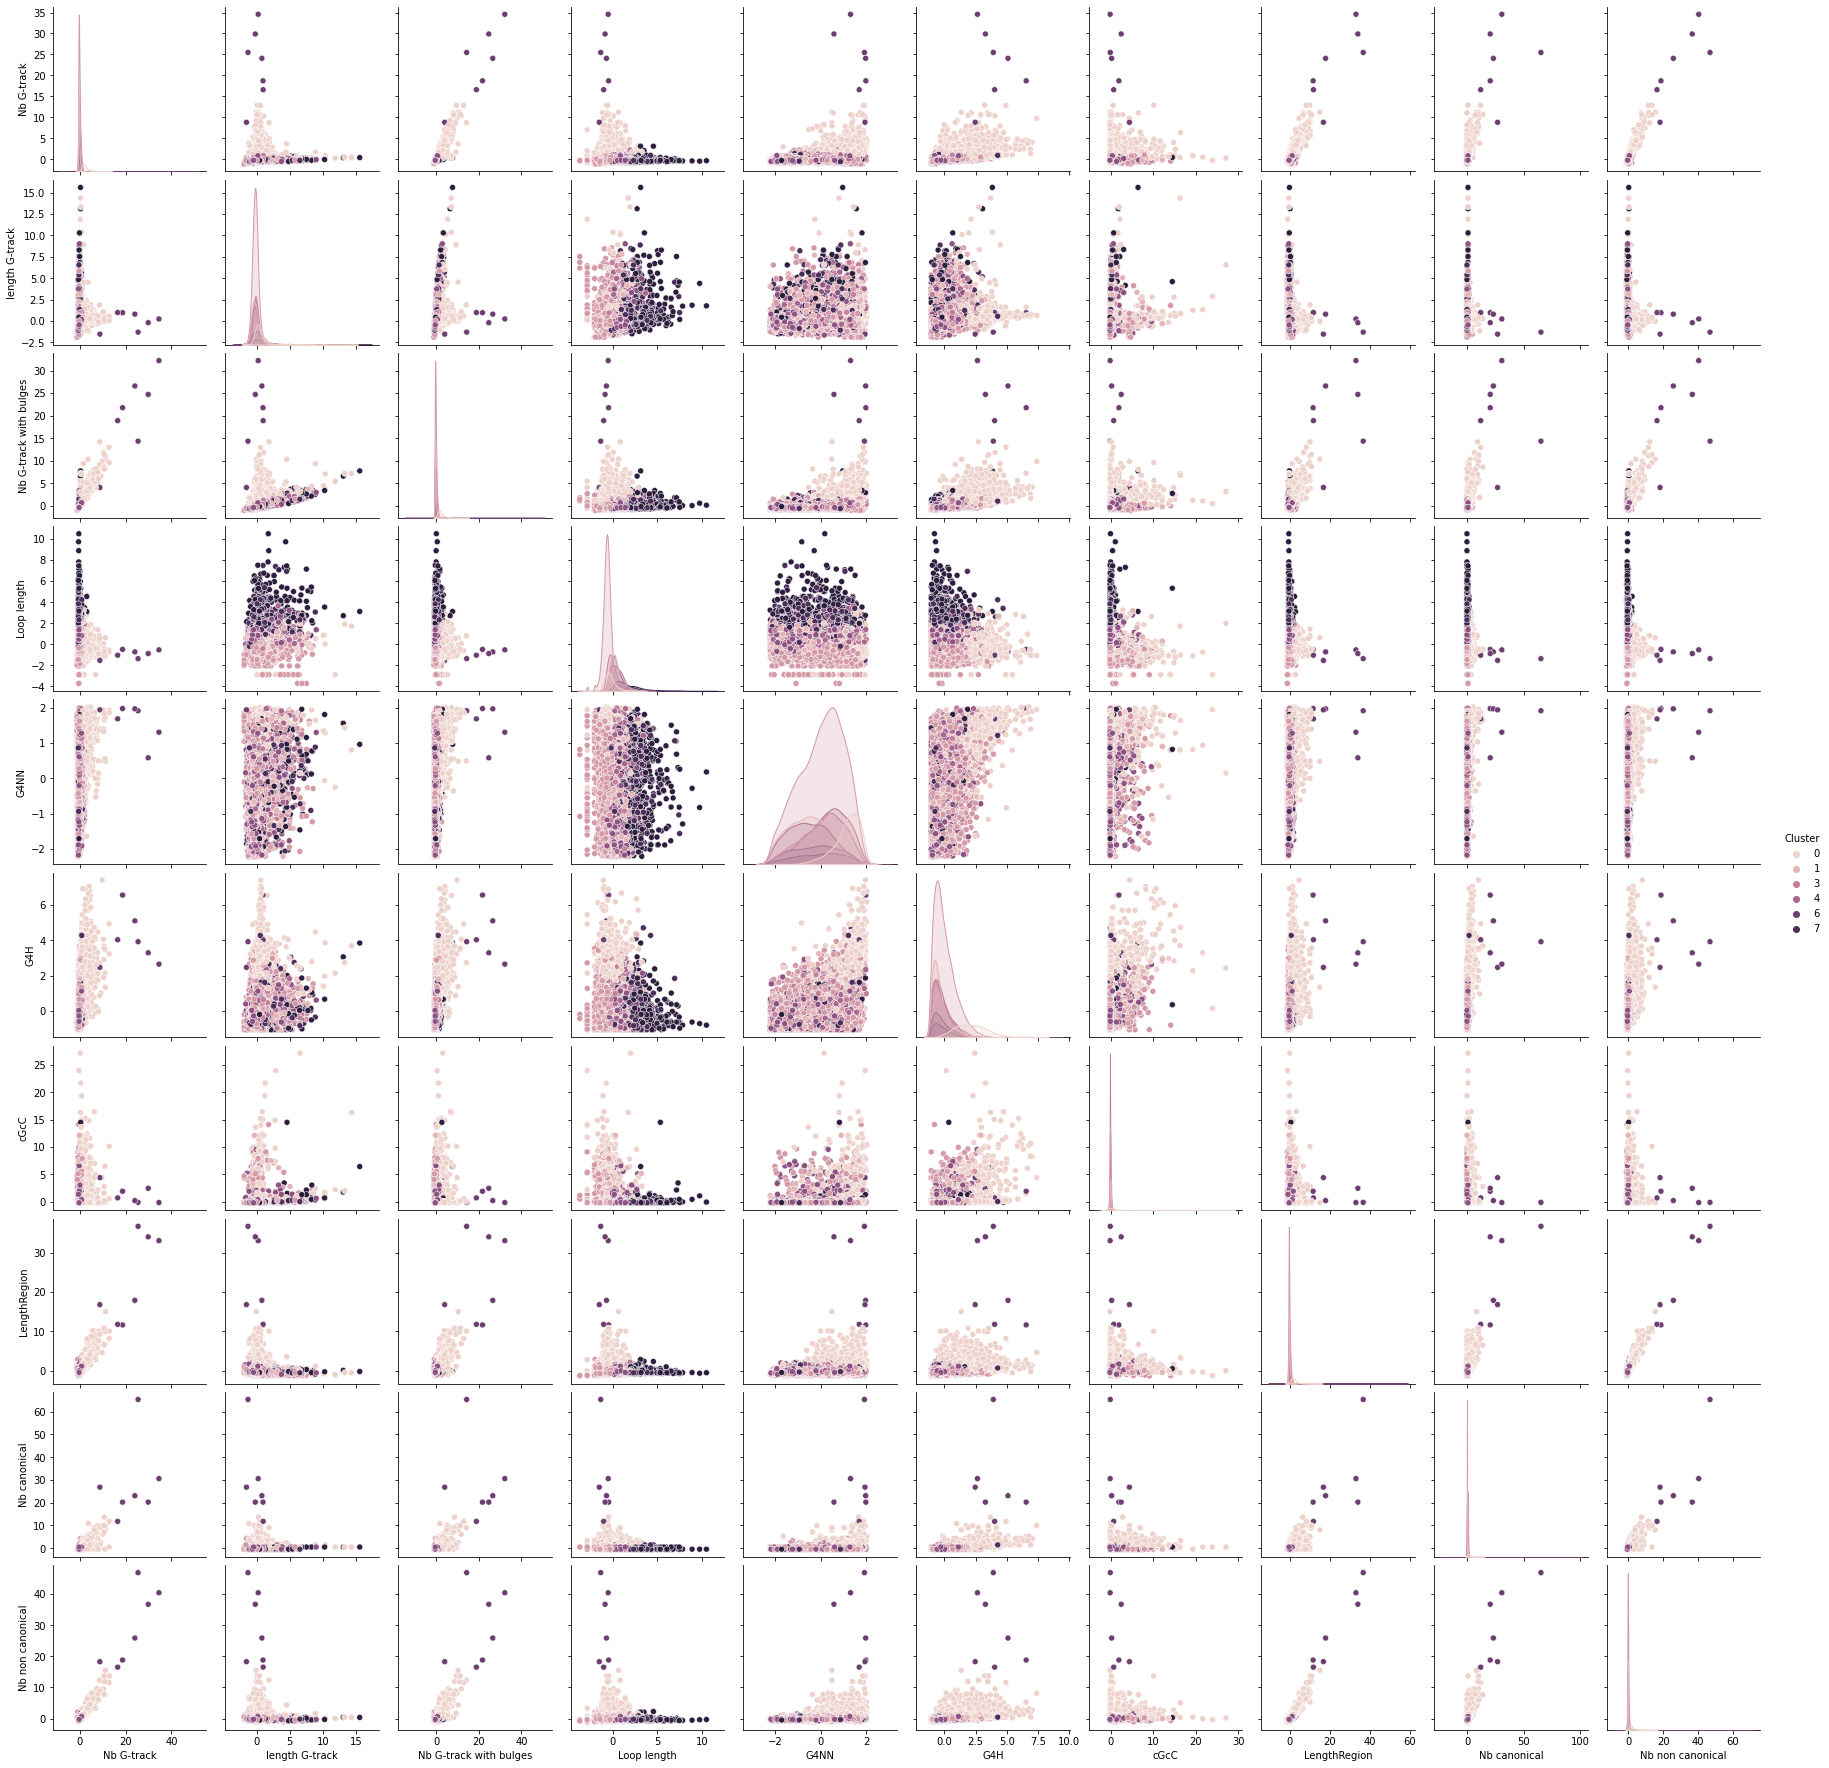

In [23]:
dfTmp = pd.DataFrame()
dfTmp = dfTmp.append(dfNormStdSc[['Nb G-track', 'length G-track', 'Nb G-track with bulges',
            'Loop length', 'G4NN', 'G4H', 'cGcC', 'LengthRegion',
            'Nb canonical', 'Nb non canonical', 'Cluster']])
sns.pairplot(dfTmp, hue='Cluster')
plt.show()

# All col except kmer
## normalisation avec StandardScaler et acp

In [24]:
# Cas avec distance euclidienne
dfShort= pd.DataFrame()
dfShort = dfShort.append(df[['Nb G-track', 'length G-track', 'Nb G-track with bulges',
            'Loop length', 'G4NN', 'G4H', 'cGcC', 'LengthRegion',
            'Nb canonical', 'Nb non canonical']])

scaler = StandardScaler()
scaler.fit(dfShort)
X_norm = scaler.transform(dfShort)
print(len(X_norm))
print(len(X_norm[0]))
X_norm

16307
10


array([[ 0.81625678, -0.01075236,  0.48665832, ...,  0.79349783,
        -0.39487133,  0.18059585],
       [-0.19003732, -0.31144591, -0.29818897, ..., -0.13317942,
        -0.39487133, -0.40152588],
       [-0.24594255, -0.29660906, -0.3674402 , ..., -0.15289596,
        -0.39487133,  0.00959027],
       ...,
       [-0.30184778, -0.01075236, -0.3674402 , ..., -0.58665978,
        -0.39487133, -0.34569529],
       [-0.24594255, -0.63291105, -0.39052394, ...,  0.02455287,
        -0.39487133, -0.50021631],
       [-0.24594255, -0.46476005, -0.3674402 , ..., -0.36977787,
         0.54378272, -0.2475688 ]])

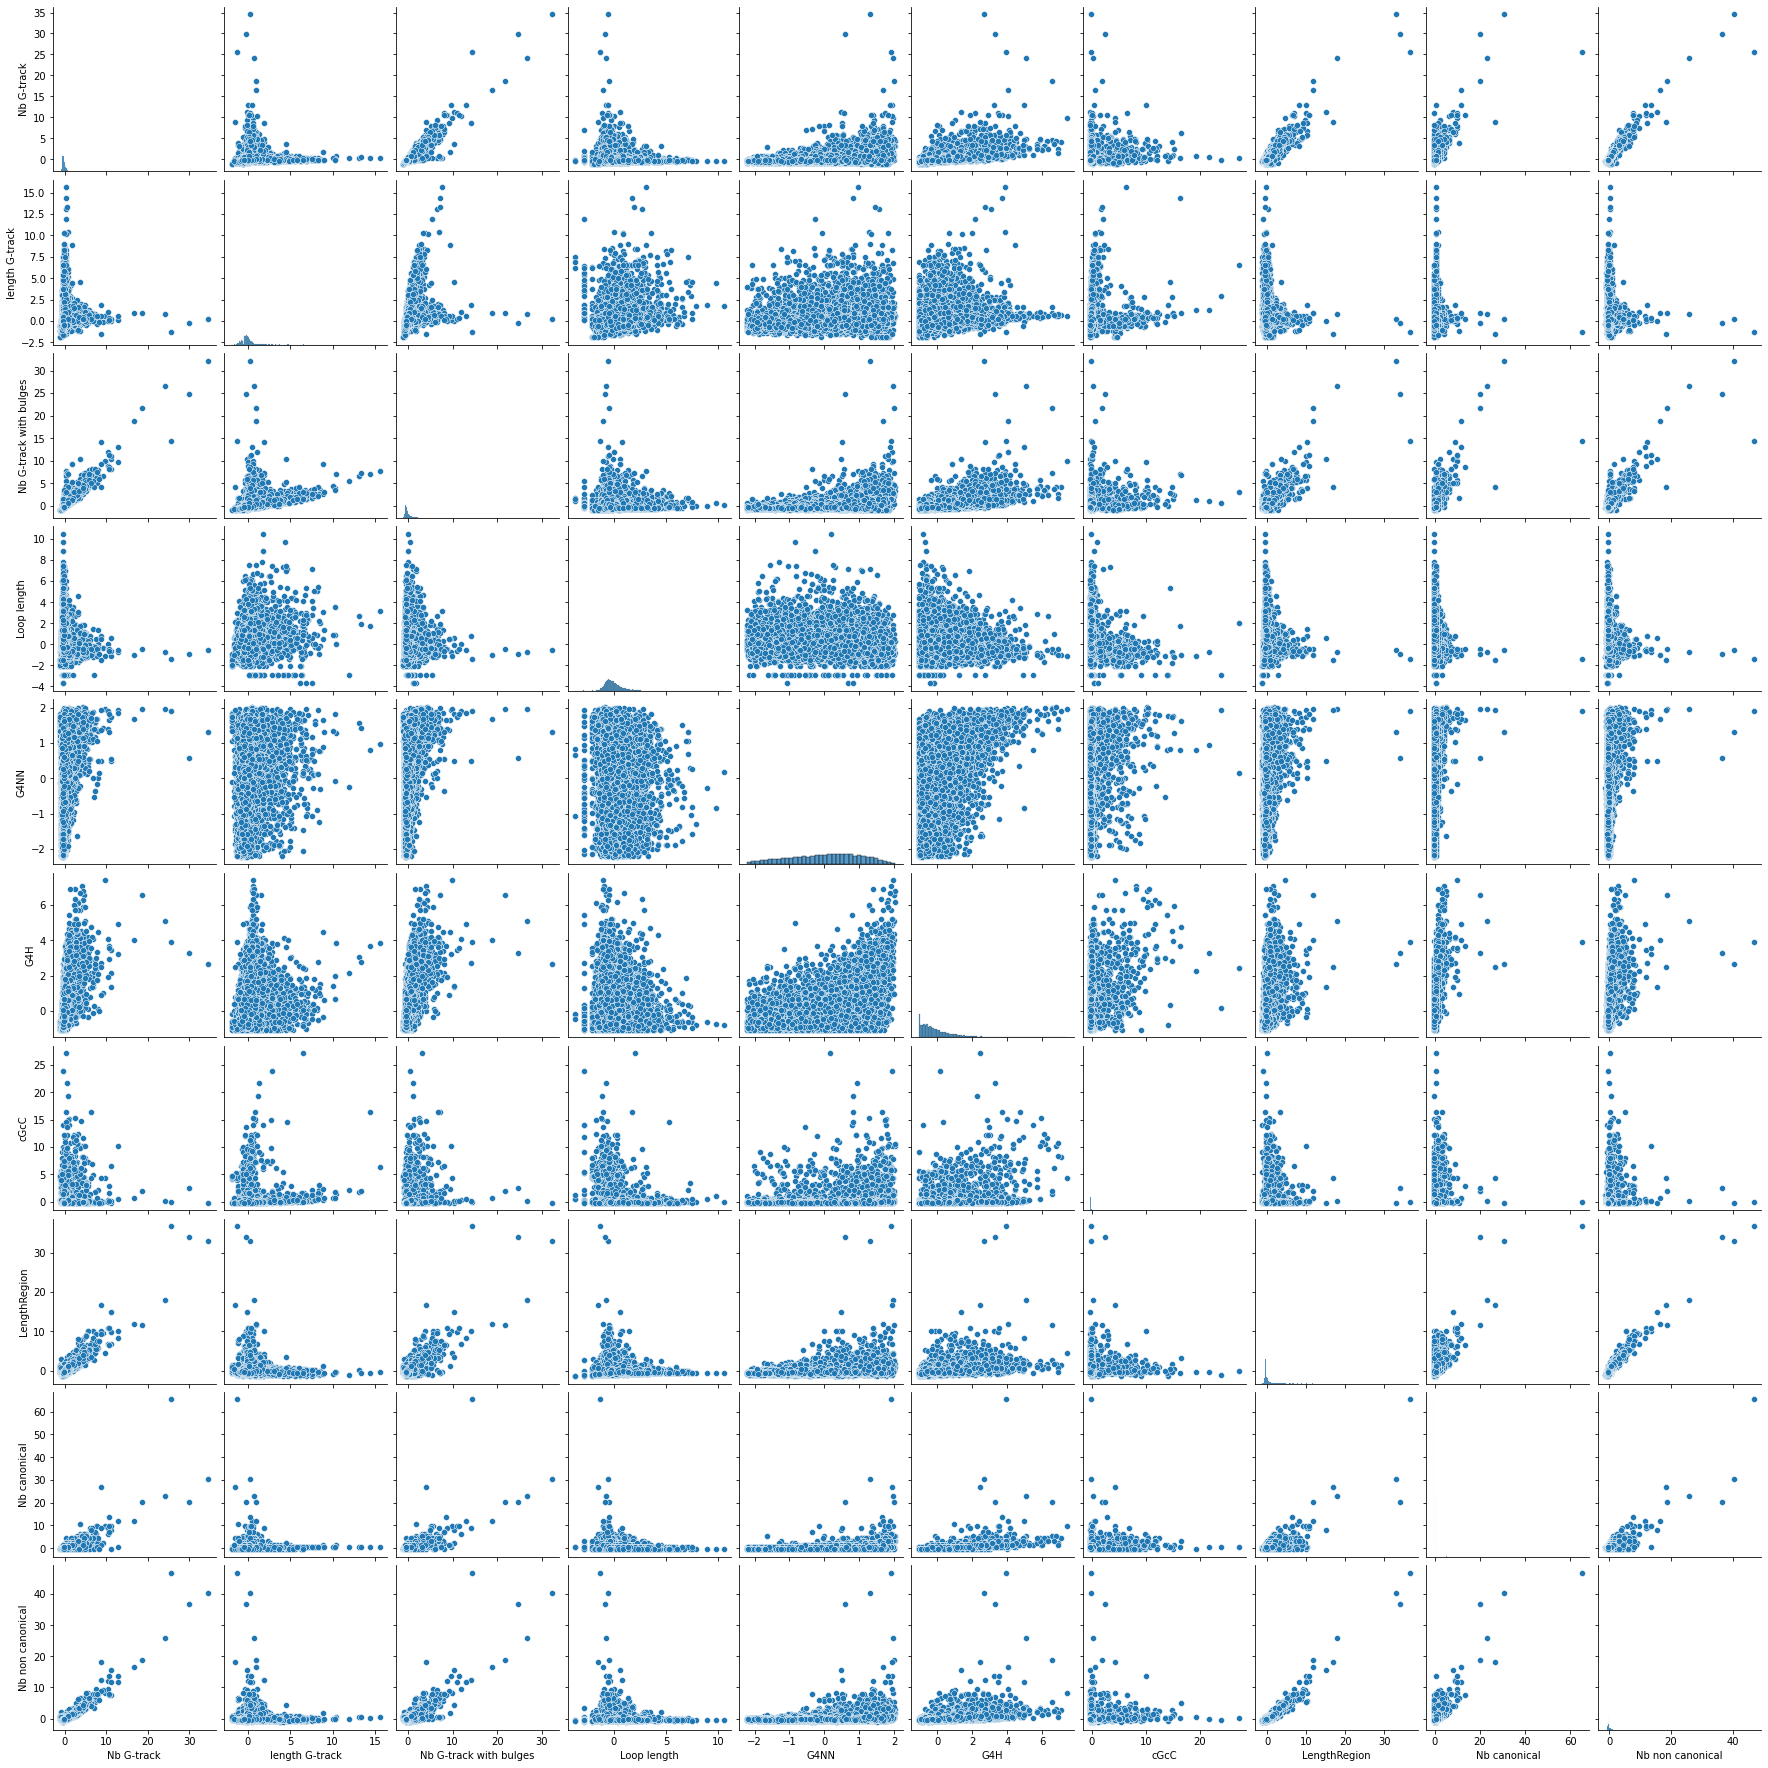

In [25]:
dfShortStdSc = pd.DataFrame(data=X_norm)
dfShortStdSc.columns = dfShort.columns
sns.pairplot(dfShortStdSc)
plt.show()

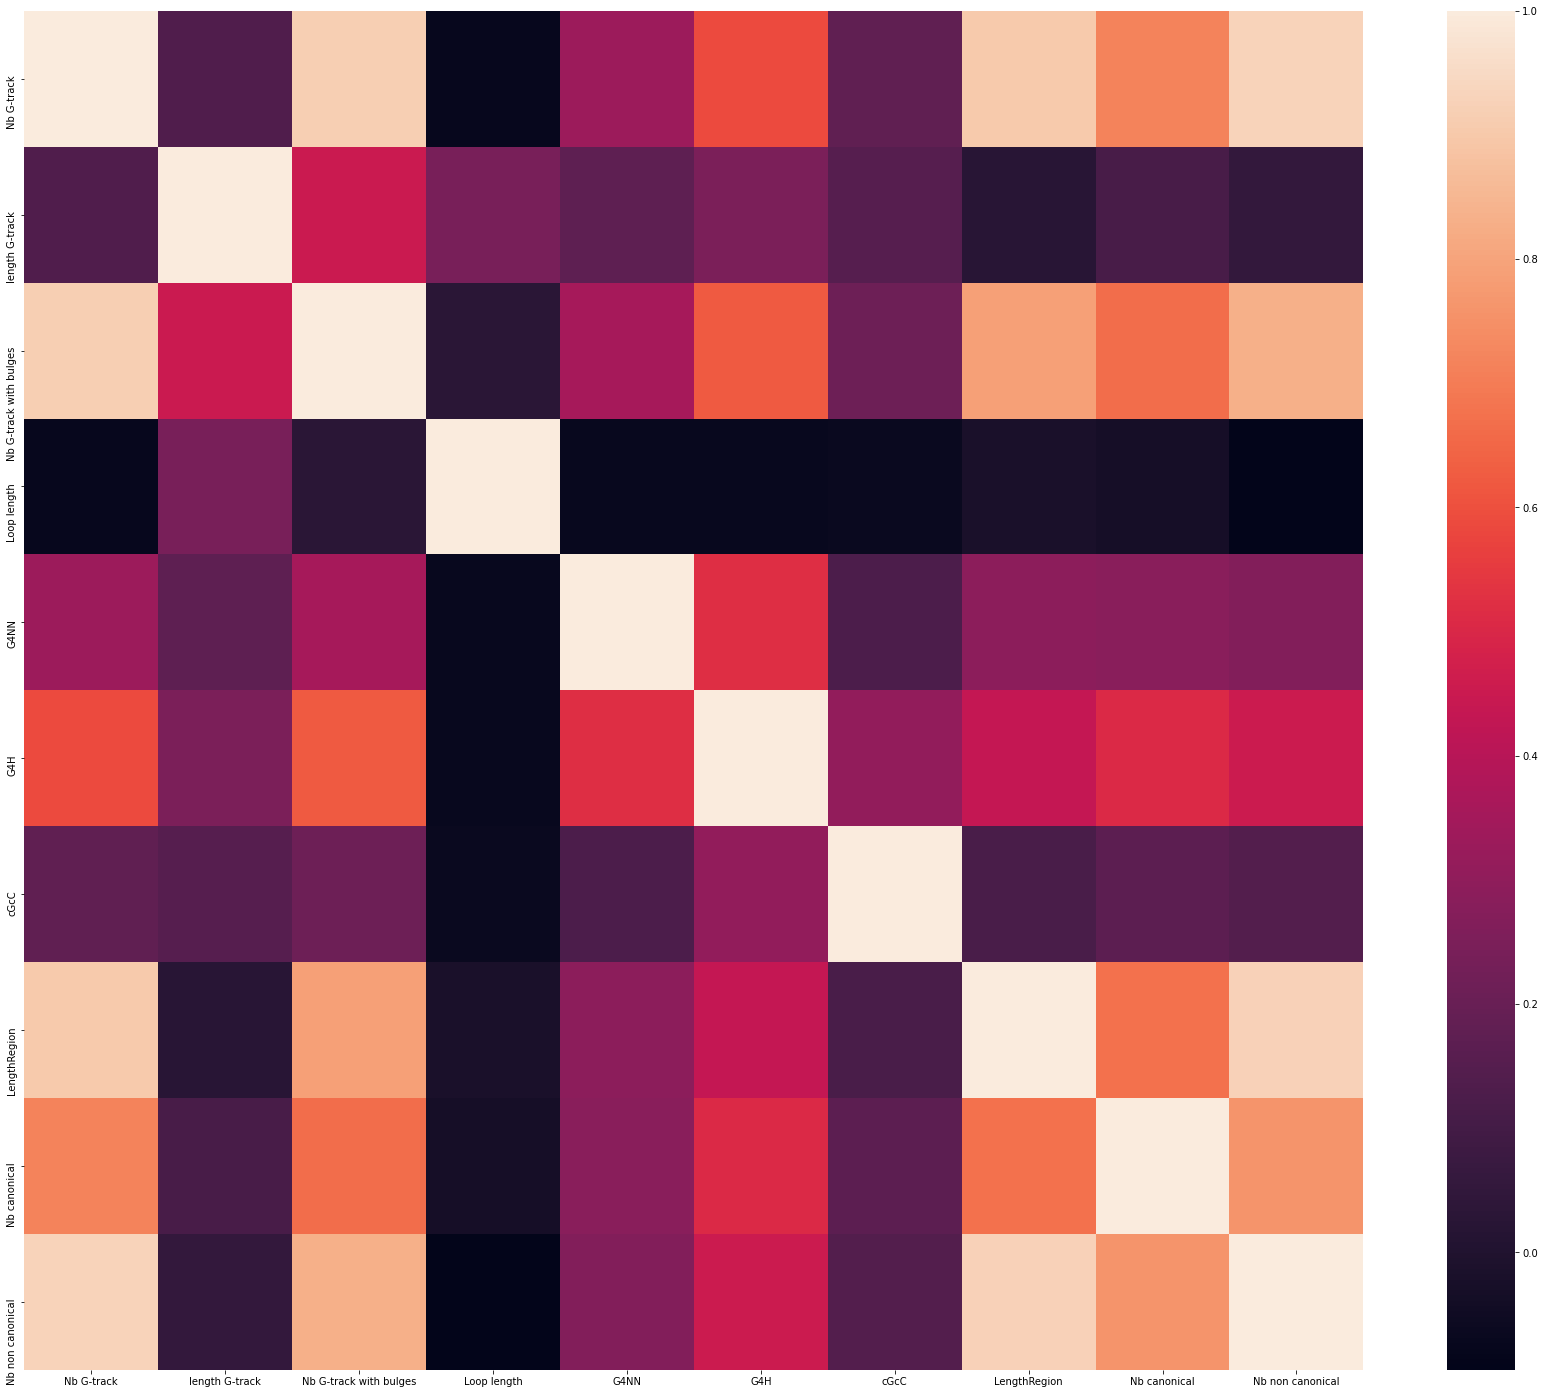

In [26]:
# calculate the correlation matrix
corr = dfShortStdSc.corr()

# plot the heatmap
plt.rcParams['figure.figsize'] = [30, 25]
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()

2
[0.49124696 0.13813672]
3
[0.49124696 0.13813672 0.11613085]
4
[0.49124696 0.13813672 0.11613085 0.08778701]
5
[0.49124696 0.13813672 0.11613085 0.08778701 0.0687624 ]
6
[0.49124696 0.13813672 0.11613085 0.08778701 0.0687624  0.04331238]
7
[0.49124696 0.13813672 0.11613085 0.08778701 0.0687624  0.04331238
 0.03739952]
8
[0.49124696 0.13813672 0.11613085 0.08778701 0.0687624  0.04331238
 0.03739952 0.00977929]
9
[0.49124696 0.13813672 0.11613085 0.08778701 0.0687624  0.04331238
 0.03739952 0.00977929 0.00512509]
10
[0.49124696 0.13813672 0.11613085 0.08778701 0.0687624  0.04331238
 0.03739952 0.00977929 0.00512509 0.00231978]


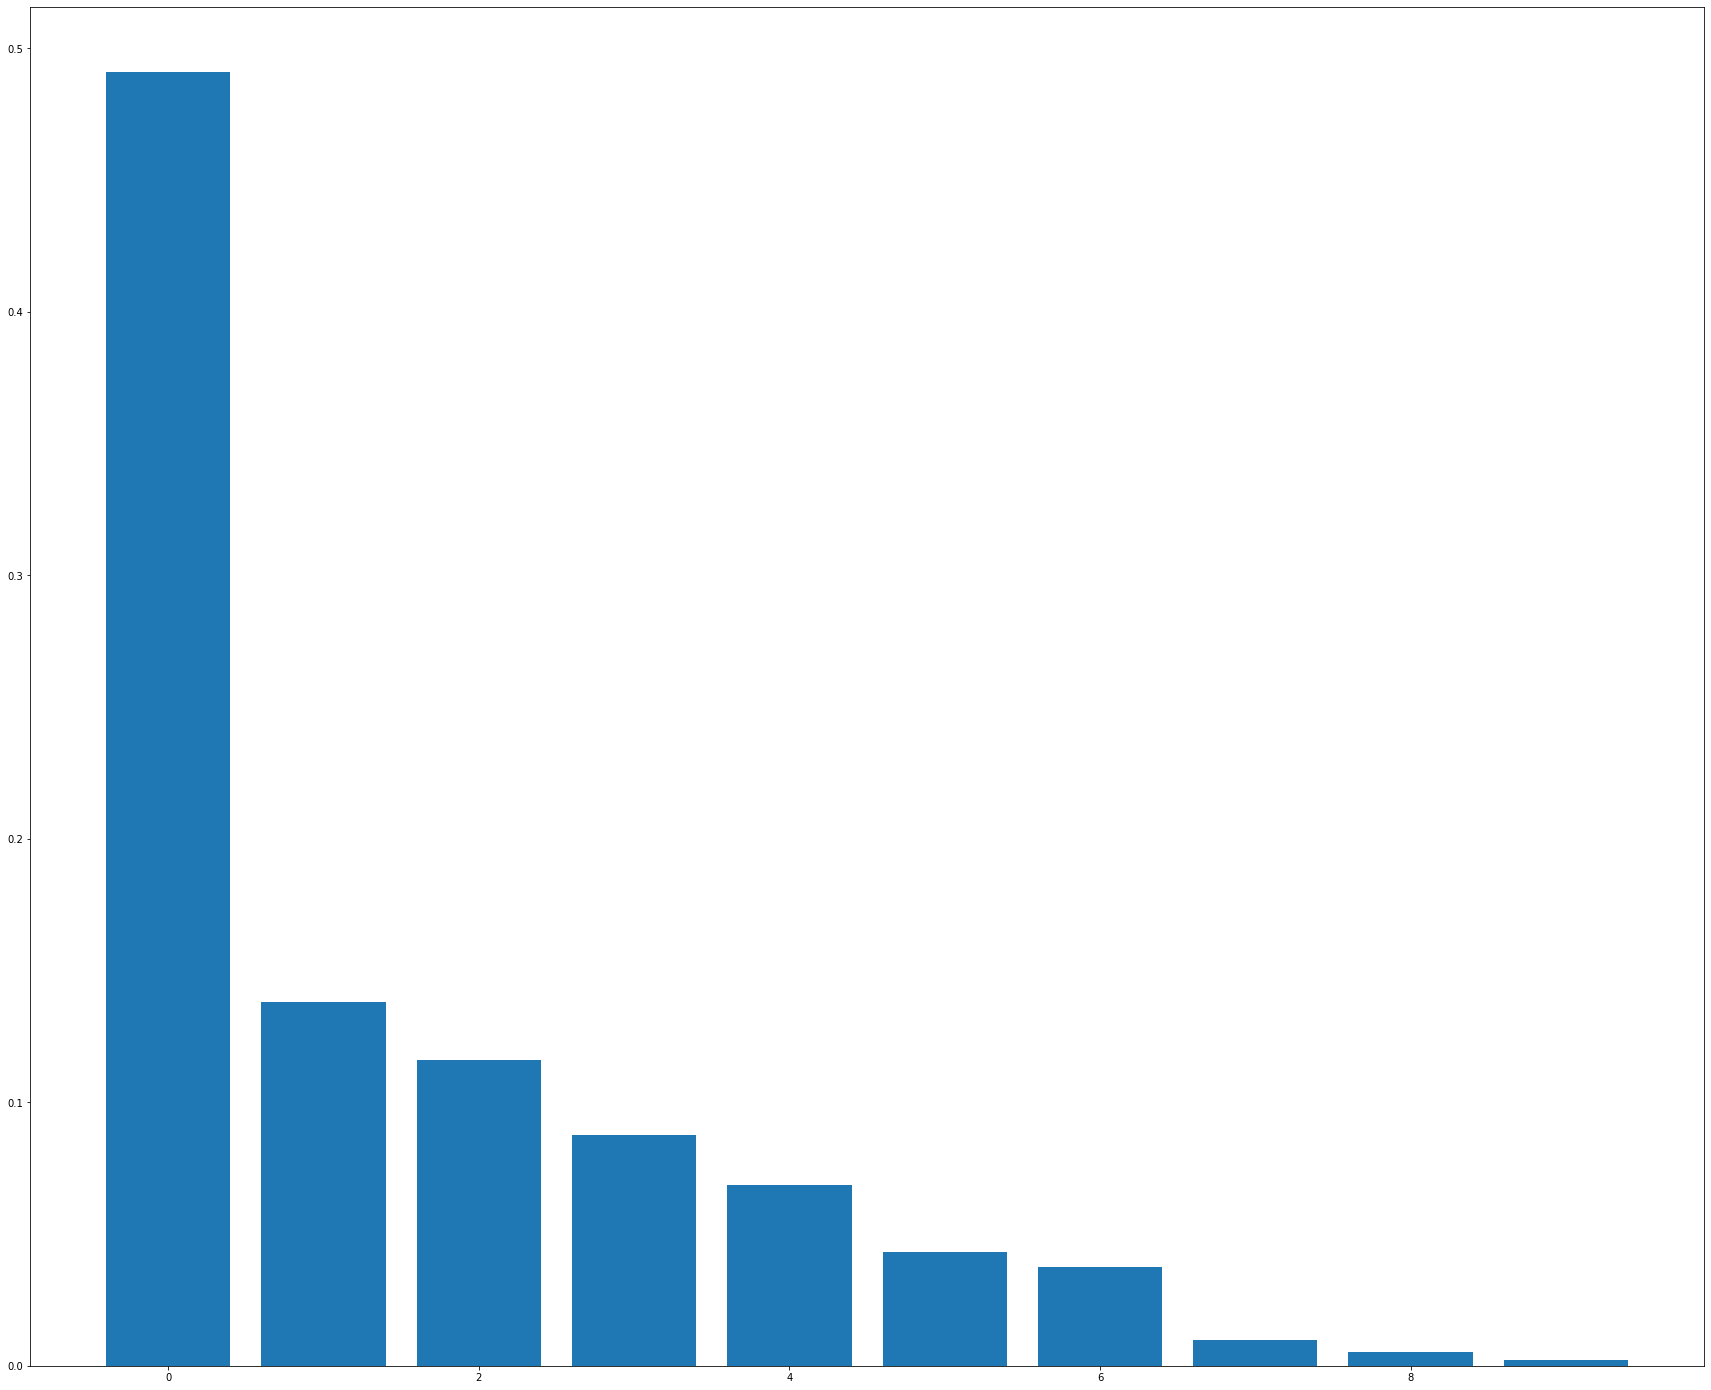

In [27]:
for i in range(2,11):
    print(i)
    pca = PCA(n_components=i)
    pca.fit(dfShortStdSc)
    print(pca.explained_variance_ratio_)
    height = pca.explained_variance_ratio_
    y_pos = np.arange(len(height))

plt.bar(y_pos, height)
plt.show()

Avec l'ACP, on expliquerais ~82% des variances avec les 4 premières cp. Cela pouvait être attendu puisque pas de corrélation existe dans le jeu de données comme vue plus haut.

In [28]:
pca = PCA(n_components=4)
pca.fit(dfShortStdSc)
X_pca4 = pca.transform(dfShortStdSc)
X_pca4

array([[ 0.49844025,  0.68192883,  0.52943733,  0.22587633],
       [-1.00818325,  0.71111526,  0.17847049,  0.56813073],
       [-0.63542442,  0.16804291,  0.02844668, -0.50916862],
       ...,
       [-0.98445888,  0.04085399, -0.28244807, -0.2519558 ],
       [-0.95190393,  0.16861313,  0.64346495,  0.06689621],
       [-0.39009582, -0.33052411,  0.63814233, -0.50146103]])

In [29]:
PCA4 = pd.DataFrame(data=X_pca4)
PCA4

0         1         2         3
0      0.498440  0.681929  0.529437  0.225876
1     -1.008183  0.711115  0.178470  0.568131
2     -0.635424  0.168043  0.028447 -0.509169
3     -0.537711  0.767415 -0.981195 -0.388223
4     -0.216571 -0.282331 -0.392569 -0.534594
...         ...       ...       ...       ...
16302 -1.083318  0.482013  0.510988  0.626399
16303  2.262967 -0.642464  0.026011 -0.531409
16304 -0.984459  0.040854 -0.282448 -0.251956
16305 -0.951904  0.168613  0.643465  0.066896
16306 -0.390096 -0.330524  0.638142 -0.501461

[16307 rows x 4 columns]

## choix nb cluster

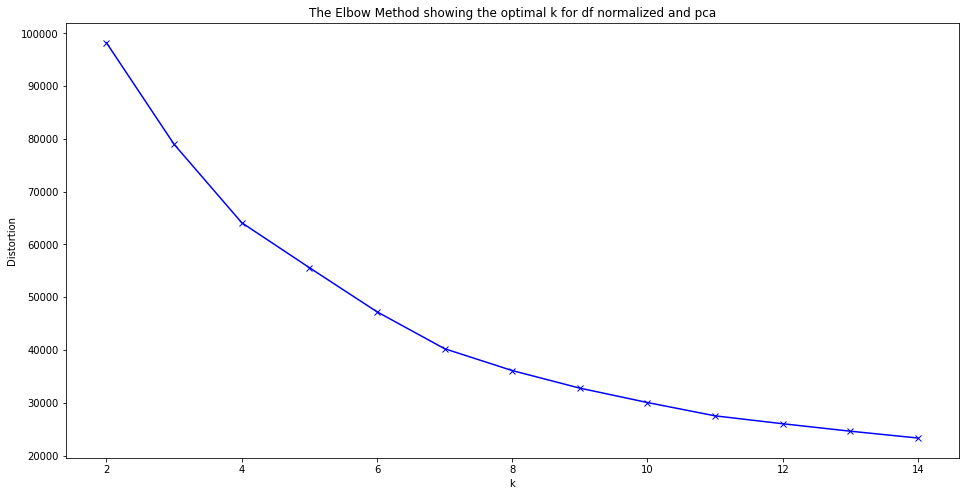

In [30]:
distortions = []
K = range(2,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(PCA4)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k for df normalized and pca')
plt.show()

Le coude semble montrer 6.

For n_clusters = 2 The average silhouette_score is : 0.6252552808189409
For n_clusters = 3 The average silhouette_score is : 0.43594856400326665
For n_clusters = 4 The average silhouette_score is : 0.39623717120897445
For n_clusters = 5 The average silhouette_score is : 0.3666009822806418
For n_clusters = 6 The average silhouette_score is : 0.39888584106450775
For n_clusters = 7 The average silhouette_score is : 0.29554028529121196
For n_clusters = 8 The average silhouette_score is : 0.27194885652949746
For n_clusters = 9 The average silhouette_score is : 0.279850921508694
For n_clusters = 10 The average silhouette_score is : 0.28563023450151714
For n_clusters = 11 The average silhouette_score is : 0.28045243374079387
For n_clusters = 12 The average silhouette_score is : 0.2731660760970719
For n_clusters = 13 The average silhouette_score is : 0.2464166361709334
For n_clusters = 14 The average silhouette_score is : 0.25168081241175855
For n_clusters = 15 The average silhouette_score is 

Text(0.5, 1.0, 'Silhouette showing the optimal k for df normalized')

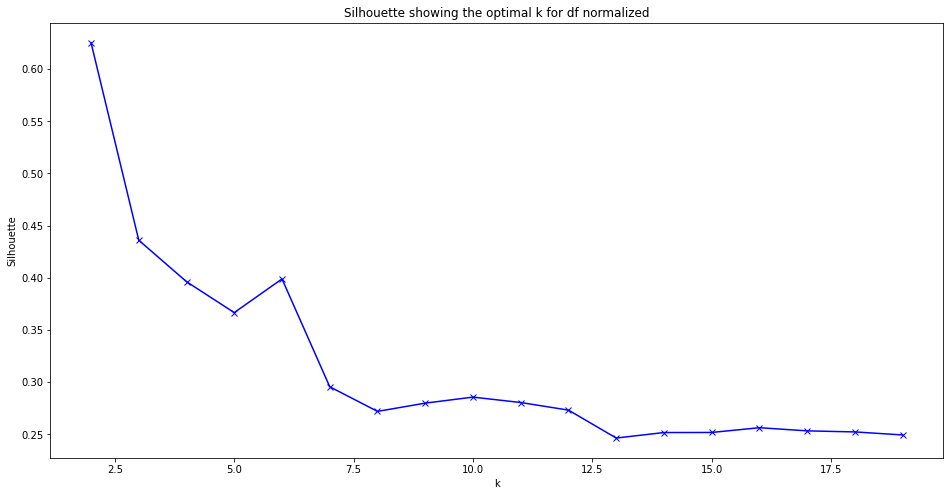

In [31]:
K = range(2,20)
distortions = []

for k in K:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusterer.fit_predict(PCA4)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(PCA4, cluster_labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)
    distortions.append(silhouette_avg)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.title('Silhouette showing the optimal k for df normalized')

The best score is 0.25, which is not that much and n=2. So it seems that our data are hard to cluster together.
## kmeans k = 6

In [32]:
kmeanModel = KMeans(n_clusters=6)
dfShortStdSc['Cluster'] = kmeanModel.fit_predict(dfShortStdSc)
dfShortStdSc

Nb G-track  length G-track  Nb G-track with bulges  Loop length  \
0        0.816257       -0.010752                0.486658    -0.280897   
1       -0.190037       -0.311446               -0.298189    -0.466873   
2       -0.245943       -0.296609               -0.367440     0.174608   
3       -0.134132       -0.399368               -0.344356    -1.297187   
4        0.145394        0.328474                0.048067    -0.403002   
...           ...             ...                     ...          ...   
16302   -0.357753       -0.741008               -0.482859     0.491182   
16303    0.816257        0.181420                0.671328     0.827093   
16304   -0.301848       -0.010752               -0.367440    -0.339132   
16305   -0.245943       -0.632911               -0.390524     0.901778   
16306   -0.245943       -0.464760               -0.367440     1.376243   

           G4NN       G4H      cGcC  LengthRegion  Nb canonical  \
0     -0.346493 -0.677408 -0.215660      0.793498     -0.394871   
1     -1.156651 -0.461176 -0.202066     -0.133179     -0.394871   
2      0.690366 -0.807147 -0.214771     -0.152896     -0.394871   
3      0.306007 -0.288190 -0.224567     -0.350061     -0.394871   
4      0.577341 -0.158451 -0.203699     -0.488077     -0.394871   
...         ...       ...       ...           ...           ...   
16302 -1.238843  0.028950 -0.093175     -0.212046     -0.394871   
16303  1.279926  1.121642  0.361410      1.207545      0.543783   
16304  0.277189 -0.720654 -0.132546     -0.586660     -0.394871   
16305 -0.207968 -0.590915 -0.120126      0.024553     -0.394871   
16306  0.608834 -0.288190 -0.214524     -0.369778      0.543783   

       Nb non canonical  Cluster  
0              0.180596        0  
1             -0.401526        0  
2              0.009590        0  
3              0.036660        0  
4             -0.132524        0  
...                 ...      ...  
16302         -0.330469        0  
16303          0.676174        4  
16304         -0.345695        0  
16305         -0.500216        0  
16306         -0.247569        0  

[16307 rows x 11 columns]

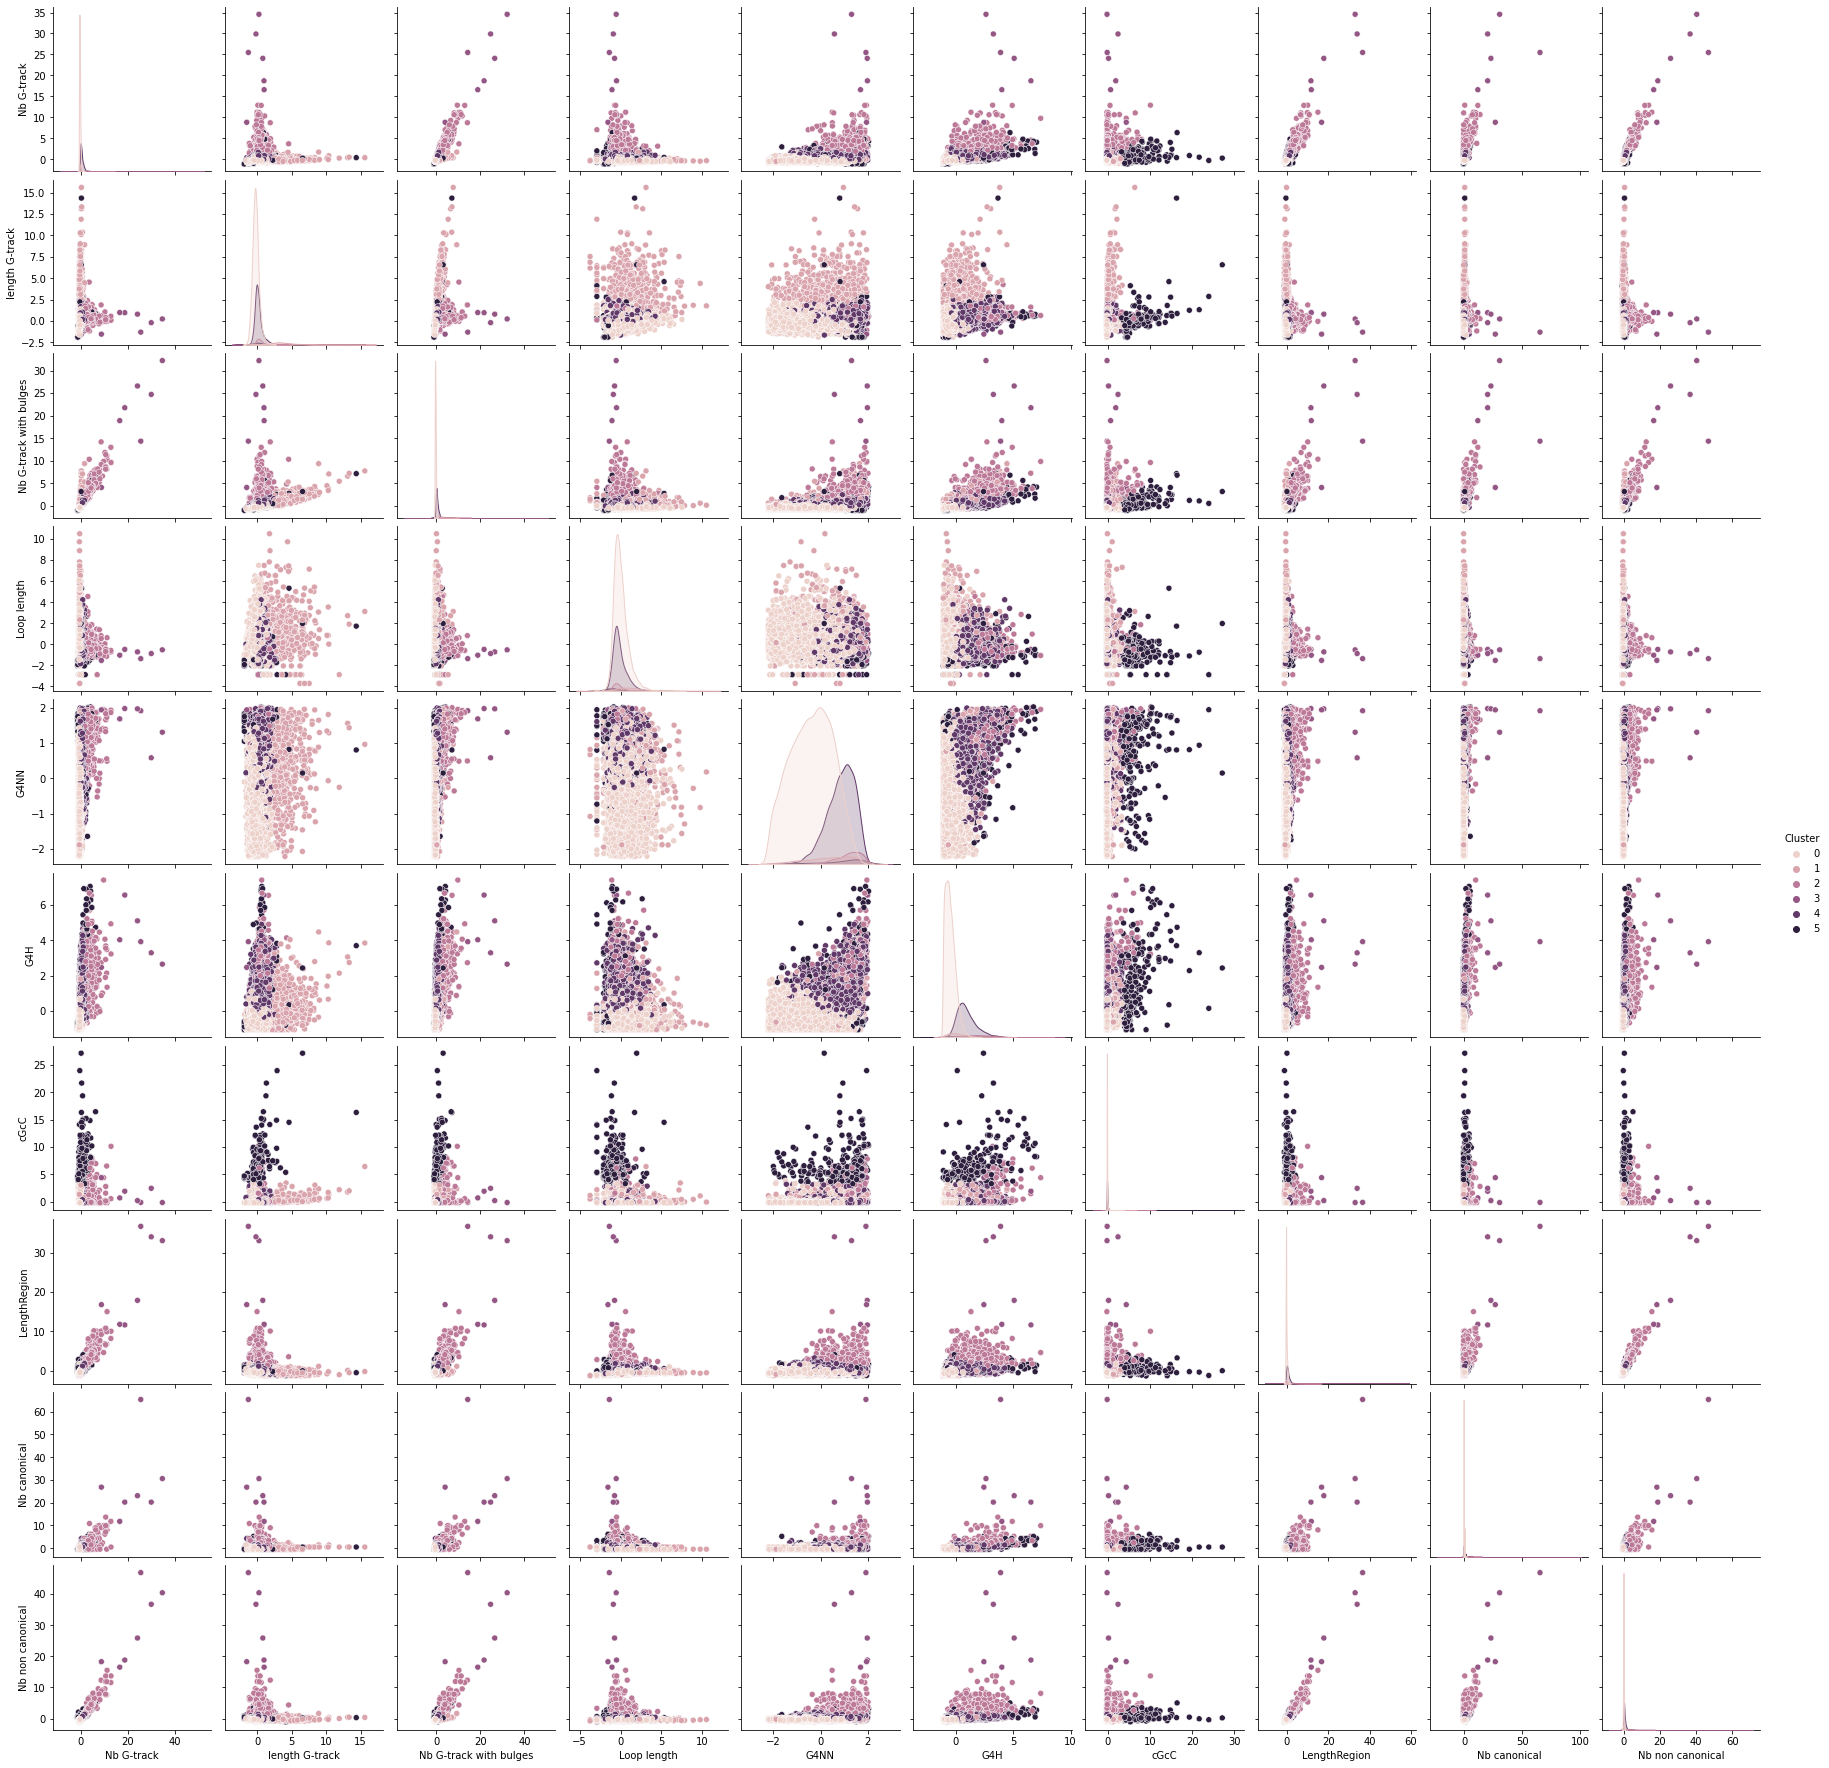

In [33]:
sns.pairplot(dfShortStdSc, hue='Cluster')
plt.show()

## kmeans k = 2

In [34]:
kmeanModel = KMeans(n_clusters=2)
dfShortStdSc['Cluster'] = kmeanModel.fit_predict(dfShortStdSc)
dfShortStdSc

Nb G-track  length G-track  Nb G-track with bulges  Loop length  \
0        0.816257       -0.010752                0.486658    -0.280897   
1       -0.190037       -0.311446               -0.298189    -0.466873   
2       -0.245943       -0.296609               -0.367440     0.174608   
3       -0.134132       -0.399368               -0.344356    -1.297187   
4        0.145394        0.328474                0.048067    -0.403002   
...           ...             ...                     ...          ...   
16302   -0.357753       -0.741008               -0.482859     0.491182   
16303    0.816257        0.181420                0.671328     0.827093   
16304   -0.301848       -0.010752               -0.367440    -0.339132   
16305   -0.245943       -0.632911               -0.390524     0.901778   
16306   -0.245943       -0.464760               -0.367440     1.376243   

           G4NN       G4H      cGcC  LengthRegion  Nb canonical  \
0     -0.346493 -0.677408 -0.215660      0.793498     -0.394871   
1     -1.156651 -0.461176 -0.202066     -0.133179     -0.394871   
2      0.690366 -0.807147 -0.214771     -0.152896     -0.394871   
3      0.306007 -0.288190 -0.224567     -0.350061     -0.394871   
4      0.577341 -0.158451 -0.203699     -0.488077     -0.394871   
...         ...       ...       ...           ...           ...   
16302 -1.238843  0.028950 -0.093175     -0.212046     -0.394871   
16303  1.279926  1.121642  0.361410      1.207545      0.543783   
16304  0.277189 -0.720654 -0.132546     -0.586660     -0.394871   
16305 -0.207968 -0.590915 -0.120126      0.024553     -0.394871   
16306  0.608834 -0.288190 -0.214524     -0.369778      0.543783   

       Nb non canonical  Cluster  
0              0.180596        1  
1             -0.401526        1  
2              0.009590        1  
3              0.036660        1  
4             -0.132524        1  
...                 ...      ...  
16302         -0.330469        1  
16303          0.676174        0  
16304         -0.345695        1  
16305         -0.500216        1  
16306         -0.247569        1  

[16307 rows x 11 columns]

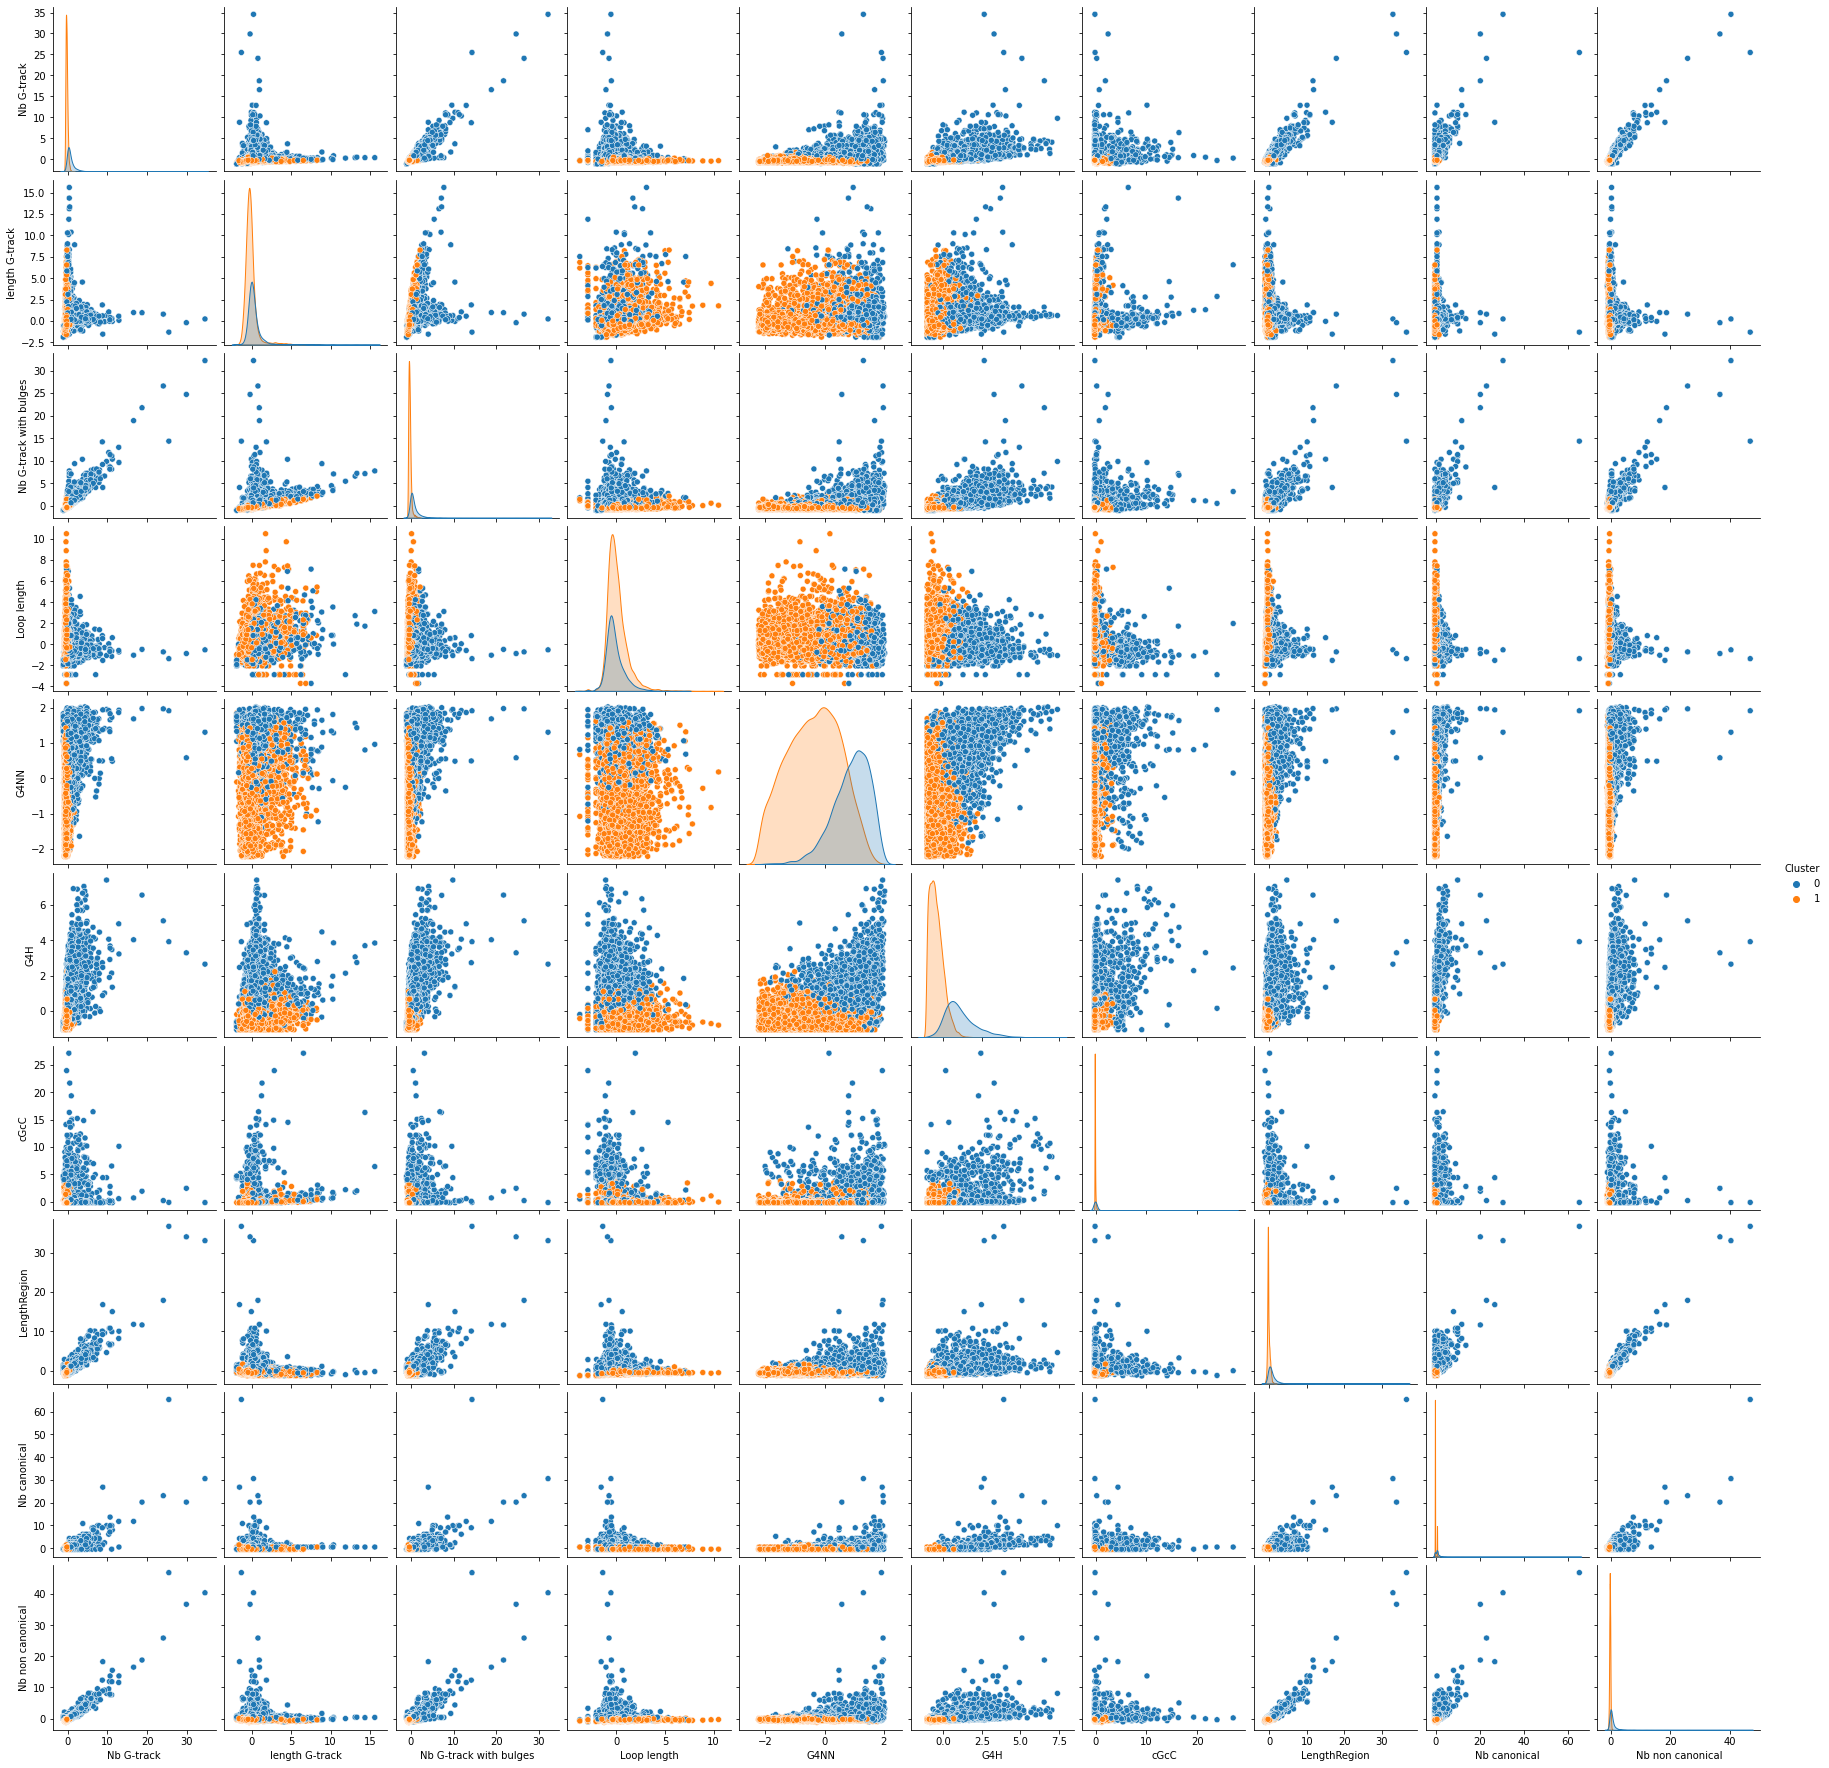

In [35]:
sns.pairplot(dfShortStdSc, hue='Cluster')
plt.show()